# Estimation of the parameters of the Ivanov model for the individuals

The goal of this notebook is find the best fit of the parameters $w_{SA}, w_{SS}, w_{PS}$ of the Ivanov model for each subject using the approximation bayesian computation and more specifically, the ABC algorithm based on Sequential Monte Carlo.

https://towardsdatascience.com/the-abcs-of-approximate-bayesian-computation-bfe11b8ca341

https://www.nature.com/articles/npre.2011.5964.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import time
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

from numpy import random
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis

import time
import multiprocessing

import sys
sys.path.append('../')
import FractalModels as fm
import FractalAnalysis as fa

In [3]:
def get_beats(subject, abnormal=False):
    """
    Get the heart rate data for a given subject

    Arguments:
    - subject:  ID of the subject to get the heart rate. Must be of the format
                "group" + "number" + "nn". Where group is n (healthy), c 
                (congestive heart failure) or a (atrial fibrillation) and the
                number is between 1 and 5.
    - abnormal: True to print the proportion of abnormal beats (i.e. noisy 
                data), False otherwise

    Returns:
    - A numpy array with the heart rate (interbeats) signal
    """
    with open('../Heart-rates-disease/' + subject + '.txt') as f:
        lines = f.readlines()

    beats = []
    
    count_abnormal = 0
    count = 0

    for line in lines:
        line = line.split()
        if line[1] != "N":
            count_abnormal += 1
        beats.append(float(line[0]))
        count += 1
    
    if abnormal:
        print("Abnormal beats: ", count_abnormal/count*100, "%")
    return np.asarray(beats)  

## Ivanov 1 parameter estimation
In this section, we can estimate the parameter $w_{SS}$ by supposing that the Ivanov model doesn't take into account $I_{SA}$ and $I_{PS}$. The code can easily be modified to chose SA or PS instead. The only method that needs to be modified is ABC_SMC_Ivanov.

### Summary statistics

In [41]:
def time_series_mean(X):
    return np.mean(X)

def time_series_variance(X):
    return np.var(X)

def time_series_autocorrelation(X, shift):

    values = pd.DataFrame(X)
    dataframe = pd.concat([values.shift(shift), values], axis=1)
    result = dataframe.corr()

    return result.to_numpy()[0][1]


def time_series_DFA(X, lower_bound, higher_bound):
    tmp = np.linspace(np.log(lower_bound), np.log(higher_bound), 30)
    lag = np.exp(tmp).astype(int)

    return fa.DFA2(X, lag)

def time_series_skewness(X):
    return skew(X)


def time_series_kurtosis(X):
    return kurtosis(X)


#### Autocorrelation

In [4]:
data = get_beats("n1nn")
#data = fm.IvanovModel(w_SA=0, w_PS=0, w_SS=0.015, N=10)

sm.tsa.acf(data, nlags = 100)

array([1.        , 0.9664624 , 0.9355104 , 0.91676442, 0.89193991,
       0.87622788, 0.87269294, 0.86599975, 0.86222625, 0.86347283,
       0.86055257, 0.85671813, 0.85489297, 0.85028561, 0.8452464 ,
       0.84178305, 0.83738259, 0.8334774 , 0.83044833, 0.82742938,
       0.82494842, 0.82355624, 0.82216678, 0.82127792, 0.82086435,
       0.81948538, 0.81807737, 0.81724894, 0.81547529, 0.81398908,
       0.81312059, 0.81149682, 0.81054355, 0.80962933, 0.80838142,
       0.8077054 , 0.80716906, 0.80661058, 0.80611358, 0.80651638,
       0.80672204, 0.80696208, 0.80752918, 0.80740579, 0.80681592,
       0.80601593, 0.80488548, 0.80427118, 0.80386063, 0.80355865,
       0.80355375, 0.8034125 , 0.80300957, 0.80295504, 0.80297384,
       0.8028341 , 0.80283878, 0.80276595, 0.8021184 , 0.80153008,
       0.80131546, 0.80118202, 0.80110343, 0.80118982, 0.80116892,
       0.80084339, 0.80056349, 0.80005169, 0.79925689, 0.79856406,
       0.79810231, 0.79789987, 0.79780669, 0.79746904, 0.79744

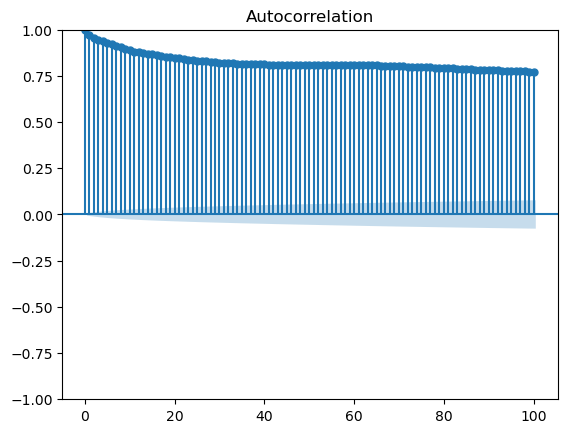

In [5]:
data = get_beats("c4nn")
plot_acf(data, lags=100)
plt.show()

### ABC implementation

In [42]:
def distance_function(X,Y):
    """
    Given two time series, computes the difference between the summary statistics. The distance
    used is the eucledian and the summary statistics chosed are:
        - the autocorrelation
        - the alpha coefficient of DFA
        - the standard deviation
    
    Arguments:
    - X: the first time series
    - Y: the second time series

    Returns:
    - the distance between the summary statistics
    """
    d1 = time_series_autocorrelation(X, 100) - time_series_autocorrelation(Y, 100)
    d2 = time_series_DFA(X, 5, 500) - time_series_DFA(Y, 5, 500)
    d3 = time_series_variance(X) - time_series_variance(Y)
    d3 *= 50
    distance = math.sqrt(d1**2 + d2**2 + d3**2)
    return distance



def theta_dist(t=0, previous_theta=[]):
    """
    Selecting the parameter value to be considered

    Arguments:
    - t: the iteration at which we are in the ABC SMC. If it is 0, the parameter
            value is selected from the prior distribution (uniform). Otherwise
            it is selected based on the previous estimation of the posterior
            distribution (more details on the selecting process available at
            https://www.nature.com/articles/npre.2011.5964.1)

    - previous_theta: list of the previous accepted estimations of the parameter
                        theta. It is a list of lists of size 2 with the first 
                        element being the value of the parameter and the second
                        being the weight of that parameter.

    Returns:
    - the new estimation of the parameter theta
    - the temporary weight (need to be normalized) of that parameter
    """

    # First iteration, use of the prior distribution
    if t == 0:
        return np.random.uniform(0, 0.1), 1
    
    # Draw theta* from the previous estimations
    sample = np.random.uniform(0, 1)
    theta_sample = previous_theta[0][0]
    cnt = 0

    for i in range(len(previous_theta)):
        cnt += previous_theta[i][1]
        if sample > cnt:
            theta_sample = previous_theta[i][0]
            break

    # Perturb with the kernel
    theta = theta_sample + np.random.normal(0, 0.01)

    # Compute the weight of the estimation
    pi_theta = 1/0.1
    sum_deno = 0

    for i in range(len(previous_theta)):
        diff = theta - previous_theta[i][0]
        sum_deno += previous_theta[i][1] * norm.pdf(diff, 0, 0.01)

    w = pi_theta/sum_deno

    return theta, w
    


def ABC_SMC_Ivanov(Observed_data, Number_of_Samples, threshold, t, previous_theta=[], start_time2=0):
    """
    Computes the estimation using ABC SMC of the parameter theta for given
    observation.

    Arguments:
    - Observed_data: the observed time series from which we want to estimate
                        the parameters
    - Number_of_Samples: the number of estimations for the parameter theta
    - treshold: the value under which the distance between the observed data
                and the signal generated with the parameter estimation must
                be under
    - t: the iteration at which the estimation is
    - previous_theta: the parameters estimations made at the previous iteration.
                        It is a list of lists of size 2 with the first element 
                        being the value of the parameter and the second being 
                        the weight of that parameter.
    - start_time: the time at which the first iteration was launched (used to 
                    stop the process if it is running for too much time)

    Returns:
    - The new parameters estimation. It is a list of lists of size 2 with the first 
        element being the value of the parameter and the second being the weight of 
        that parameter.

    """

    #initialise Posterior array
    Posterior_distribution = []

    norm_factor = 0

    #loop through to get the samples. 
    for i in tqdm(range(Number_of_Samples)):
        distance = threshold+1
        #While the distance is greater than the threshold continue to sample theta from the beta distribution
        while distance > threshold:
            if time.time() - start_time2 > 7200 and i < Number_of_Samples - Number_of_Samples/5:
                return []
            #sample theta from the prior
            theta, w = theta_dist(t, previous_theta)
            # generate the sim data 
            X = fm.IvanovModel(w_SA=0, w_SS=theta, w_PS=0, Num_beats=5000, N=10)
            # calcalute the distance from Y 
            distance = distance_function(X,Observed_data)

        Posterior_distribution.append([theta, w])
        norm_factor += w

    # Normalize weights
    for i in range(len(Posterior_distribution)):
        Posterior_distribution[i][1] /= norm_factor

    return Posterior_distribution


In [44]:
thresholds1 = np.linspace(1, 0.1, 20)
thresholds2 = np.linspace(0.098, 0.01, 20)
thresholds3 = np.linspace(0.0098, 0.005, 20)
thresholds = np.concatenate((thresholds1, thresholds2, thresholds2))

### One subject
Performs the parameter estimation on one subject.

Abnormal beats:  0.0 %


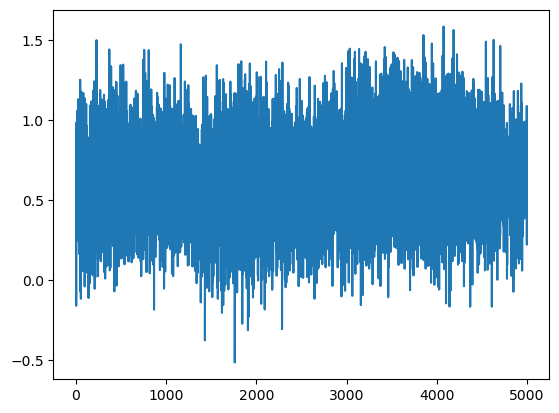

100%|██████████| 100/100 [03:59<00:00,  2.39s/it]

1.0


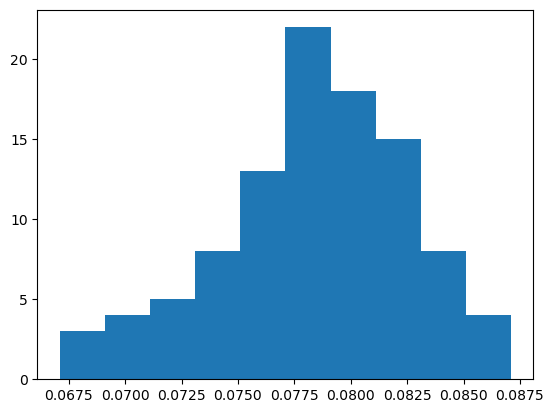

100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

0.9526315789473684


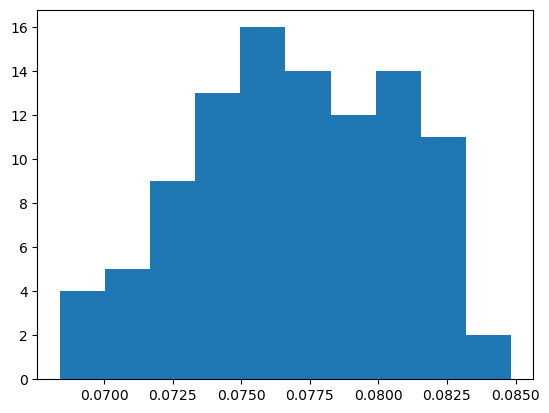

100%|██████████| 100/100 [01:44<00:00,  1.05s/it]

0.9052631578947369


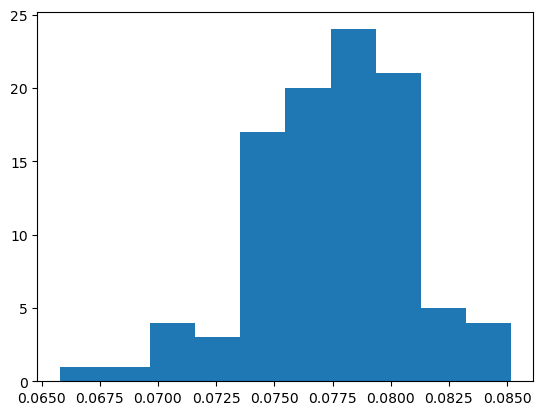

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

0.8578947368421053


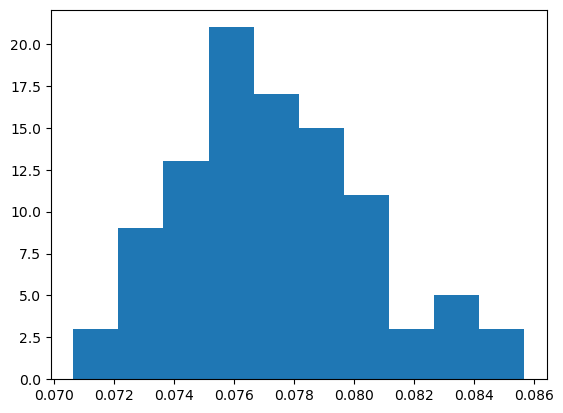

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]

0.8105263157894737


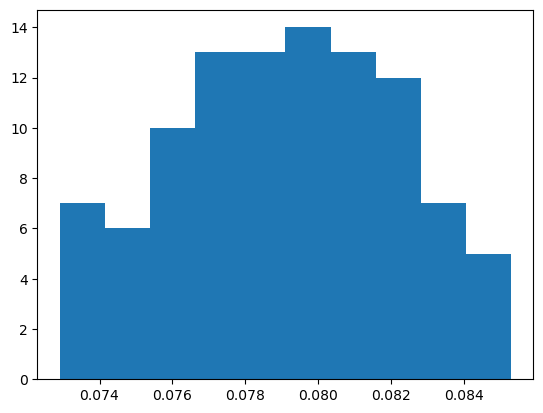

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


0.763157894736842


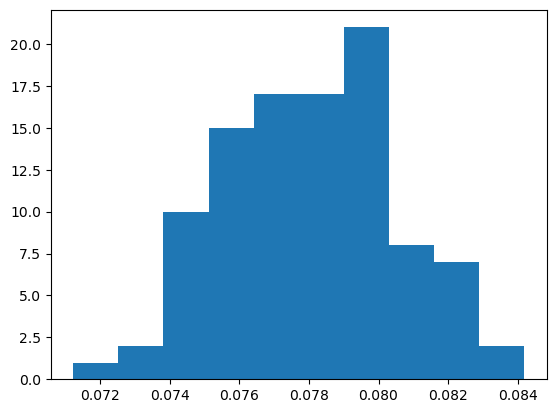

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


0.7157894736842105


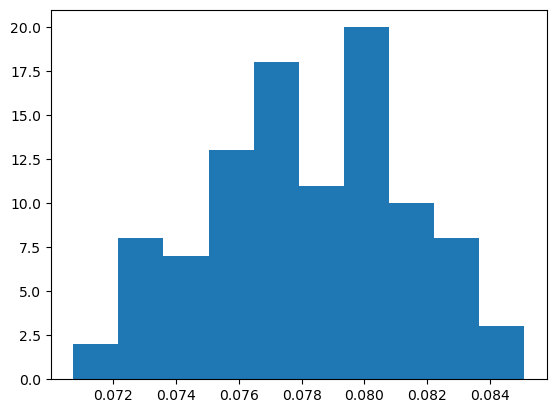

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

0.6684210526315789


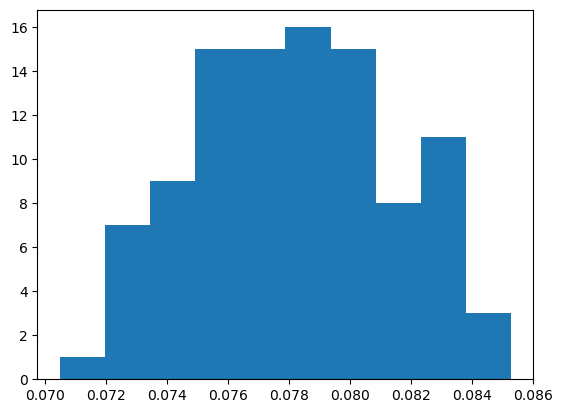

100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

0.6210526315789473


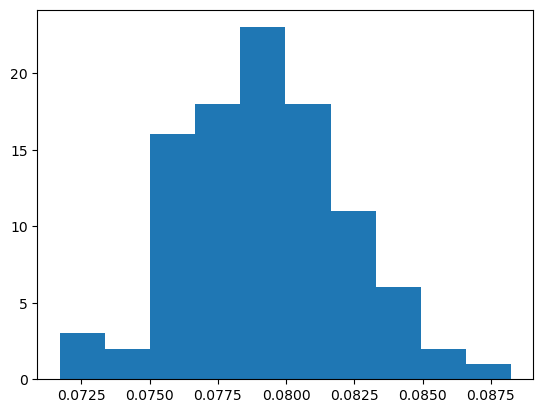

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]

0.5736842105263158


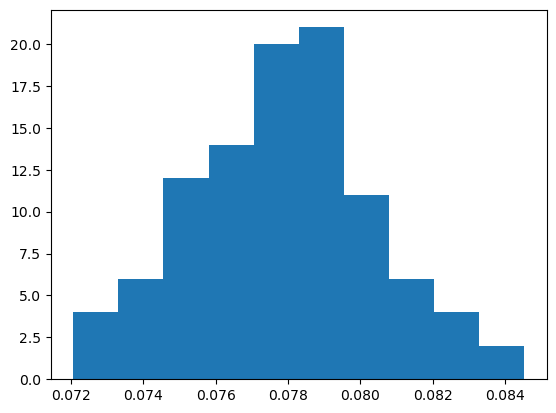

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

0.5263157894736842


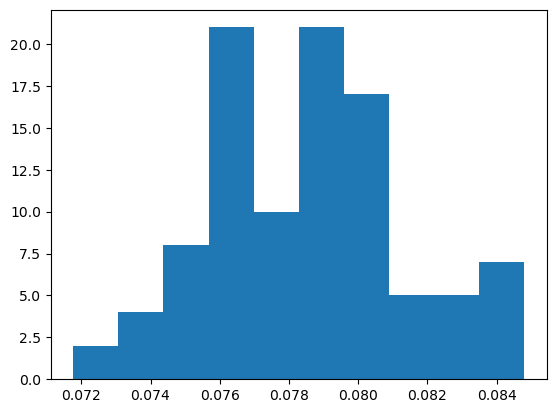

100%|██████████| 100/100 [02:08<00:00,  1.28s/it]

0.47894736842105257


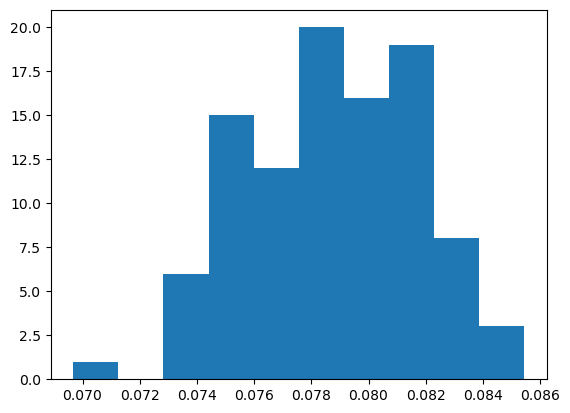

100%|██████████| 100/100 [02:23<00:00,  1.43s/it]

0.43157894736842106


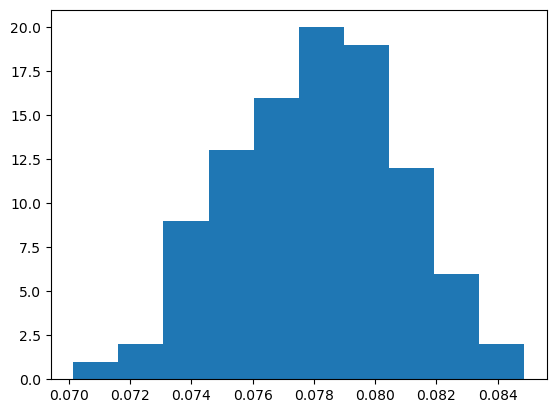

100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


0.38421052631578945


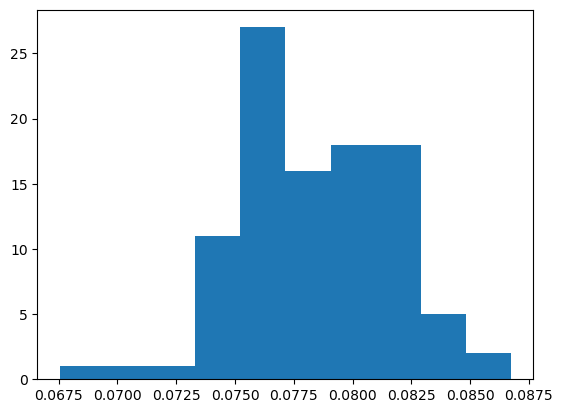

100%|██████████| 100/100 [02:39<00:00,  1.59s/it]

0.33684210526315783


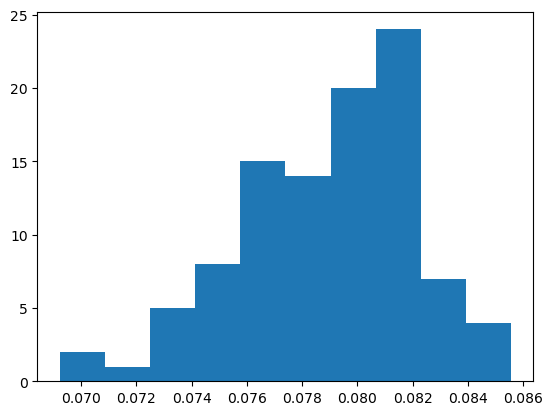

100%|██████████| 100/100 [03:16<00:00,  1.96s/it]

0.2894736842105263


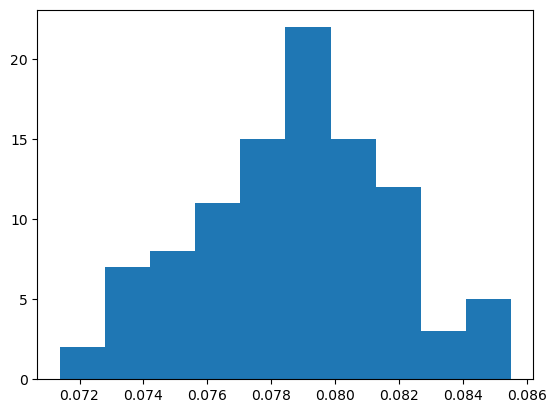

100%|██████████| 100/100 [03:51<00:00,  2.31s/it]

0.2421052631578947


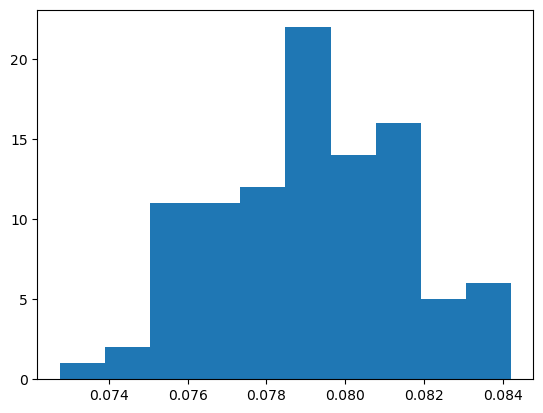

100%|██████████| 100/100 [05:38<00:00,  3.38s/it]

0.1947368421052631


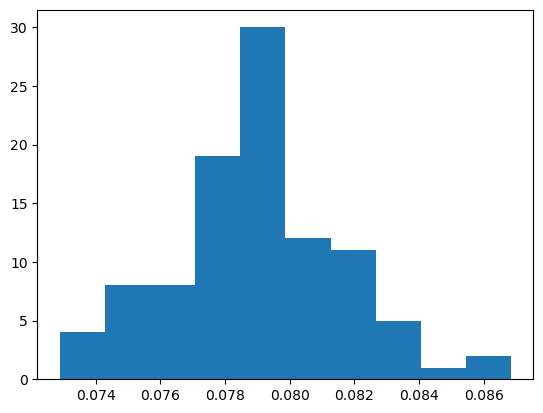

100%|██████████| 100/100 [07:12<00:00,  4.32s/it]

0.1473684210526316


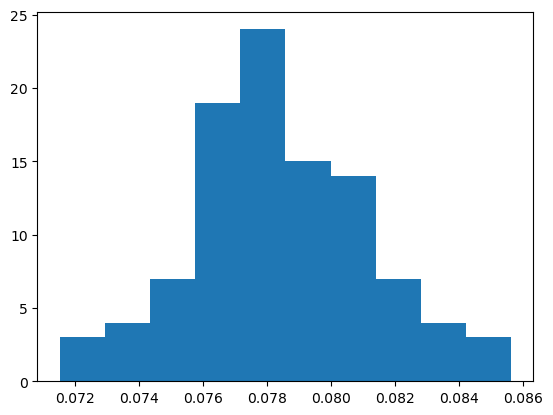

100%|██████████| 100/100 [15:58<00:00,  9.59s/it]

0.1


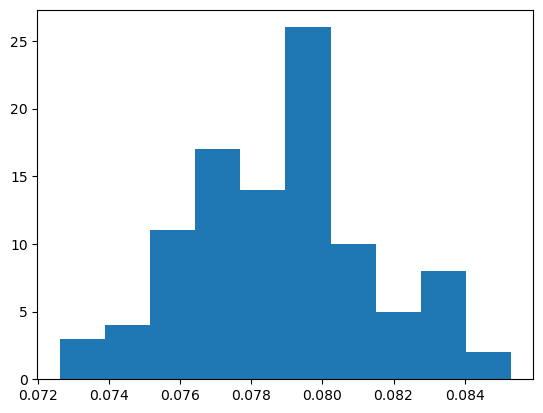

100%|██████████| 100/100 [15:49<00:00,  9.49s/it]

0.098


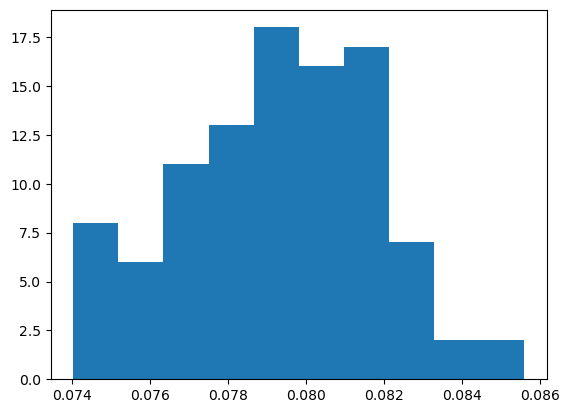

100%|██████████| 100/100 [22:53<00:00, 13.73s/it]

0.09336842105263159


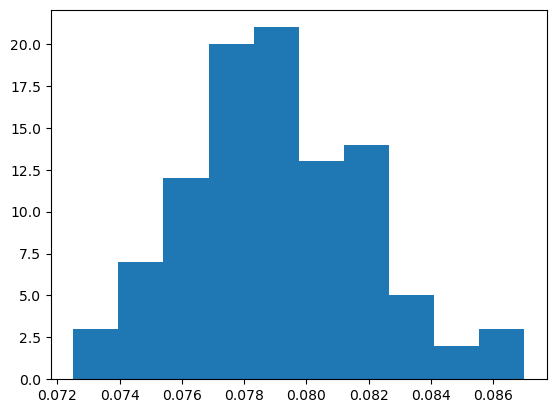

 71%|███████   | 71/100 [16:17<06:39, 13.76s/it]


In [38]:
# Load heart rate signal
subject = "n2"
n = get_beats(subject + "nn", abnormal=True)
data = n[0:5000]

#data = fm.IvanovModel(w_SA=0, w_SS=0.075, w_PS=0, Num_beats=5000, std_eta=math.sqrt(2)*0.5, N=10)

plt.plot(data)
plt.show()

t = 0
result = []
start_time = time.time()

# ABC SMC
for thresh in thresholds:
    result = ABC_SMC_Ivanov(data, 100, thresh, t, result, start_time)
    t += 1

    if(len(result)==0):
        break

    theta_result = []

    for j in range(len(result)):
        theta_result.append(result[j][0])
    
    # Plot the iteration estimations
    print(thresh)
    plt.hist(theta_result)
    plt.show()

Mean:  0.07903825184116343


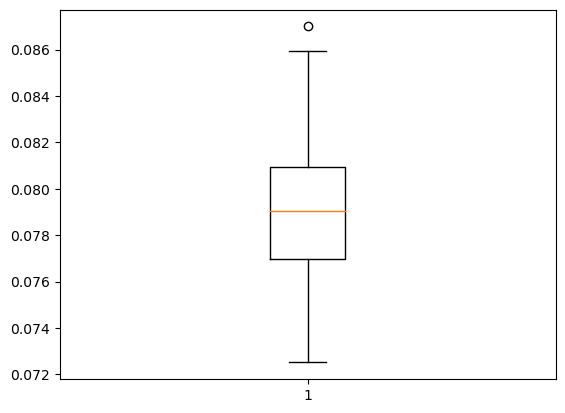

In [39]:
print("Mean: ", np.mean(theta_result))
plt.boxplot(theta_result)
plt.show()

### Several subjects
Performs the parameter estimation for several subjects at a time

Abnormal beats:  0.0 %


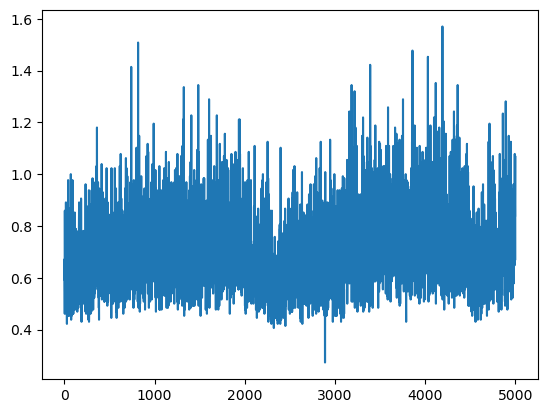

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


1.0


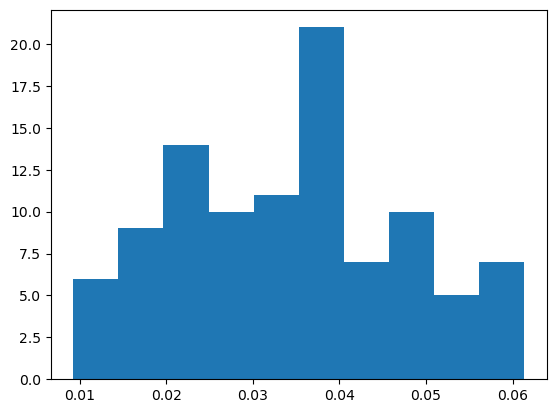

100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


0.9526315789473684


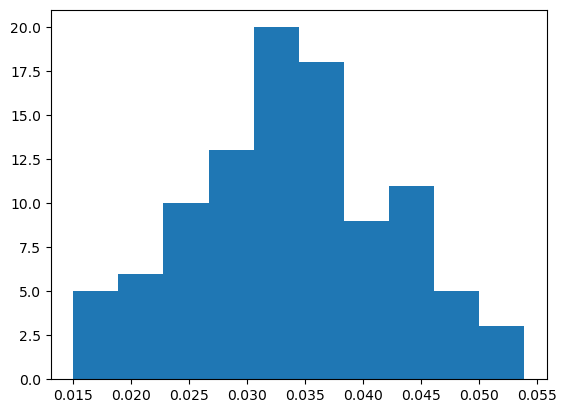

100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


0.9052631578947369


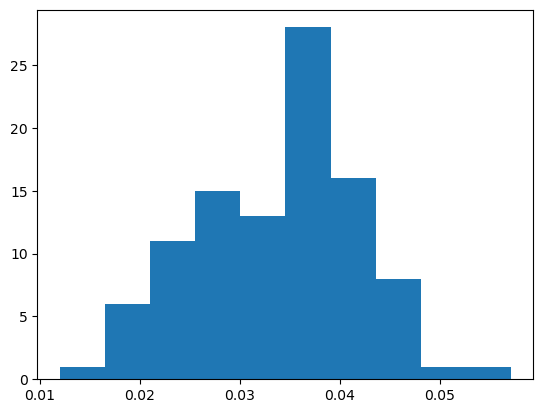

100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


0.8578947368421053


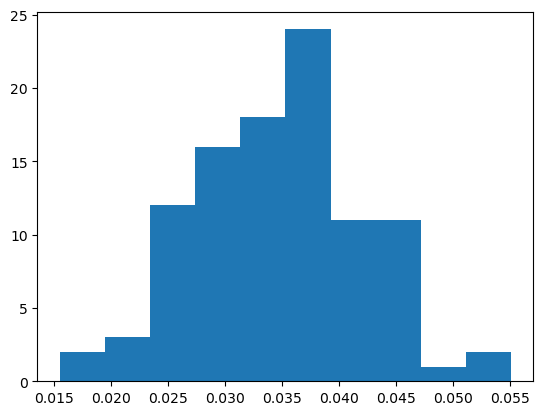

100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


0.8105263157894737


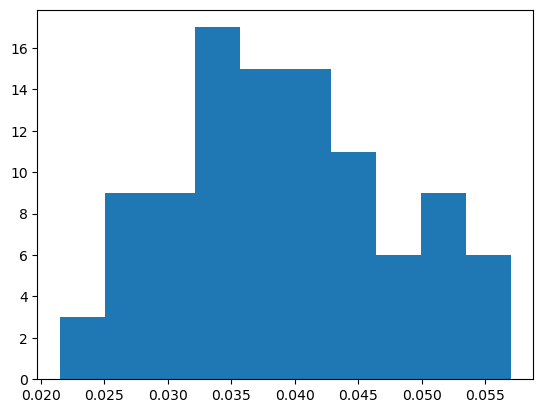

100%|██████████| 100/100 [00:20<00:00,  4.95it/s]

0.763157894736842


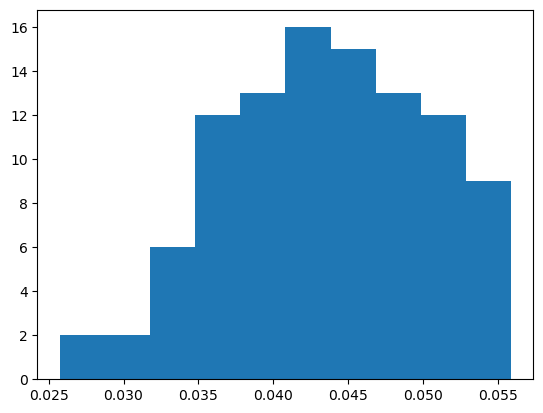

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]

0.7157894736842105


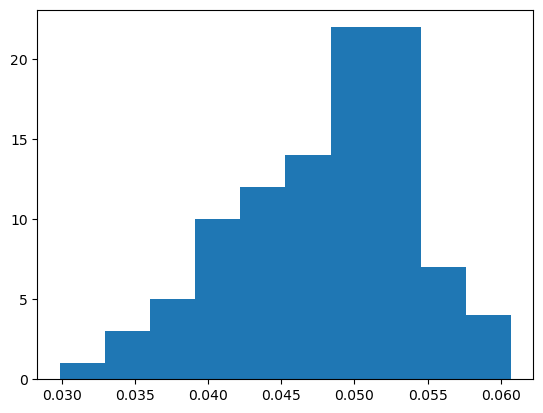

100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


0.6684210526315789


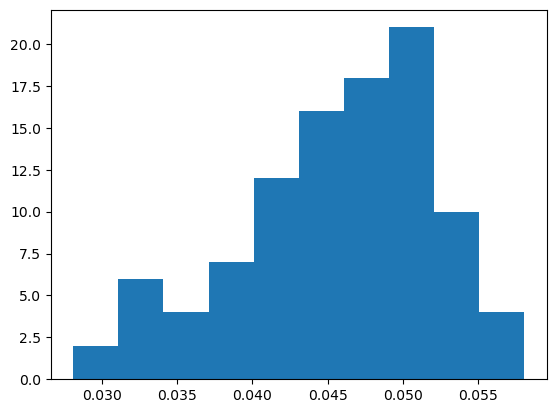

100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


0.6210526315789473


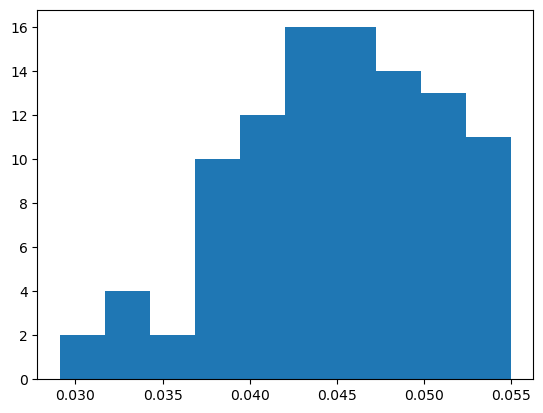

100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


0.5736842105263158


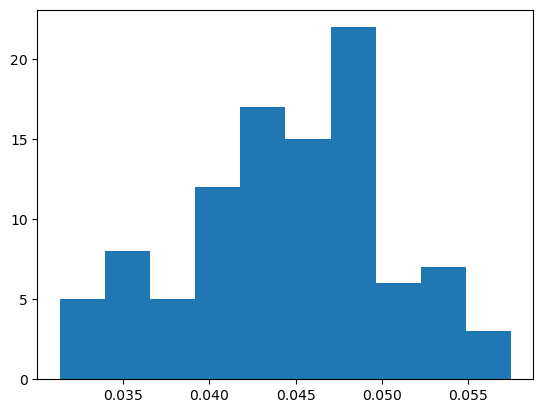

100%|██████████| 100/100 [00:23<00:00,  4.35it/s]

0.5263157894736842


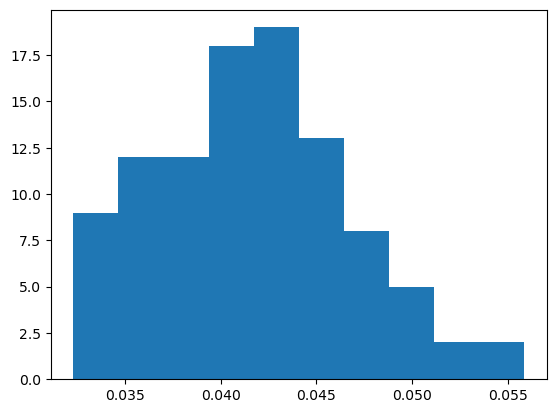

100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


0.47894736842105257


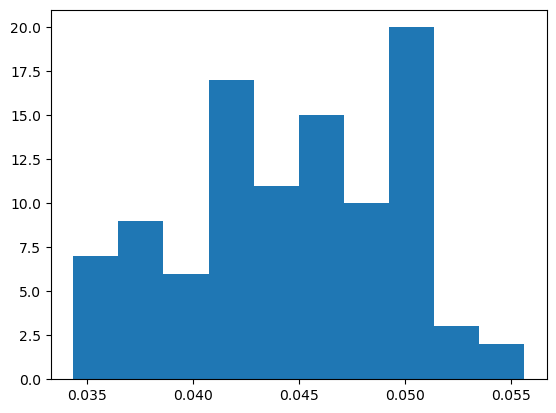

100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


0.43157894736842106


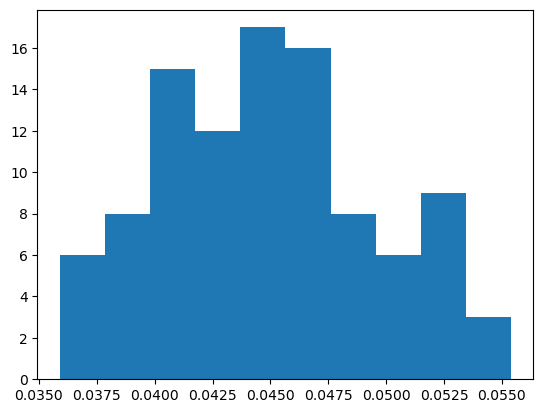

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


0.38421052631578945


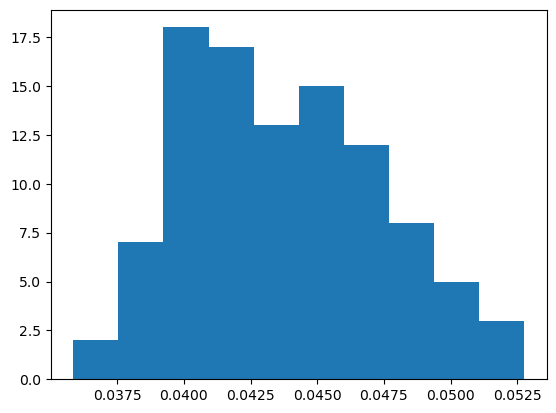

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

0.33684210526315783


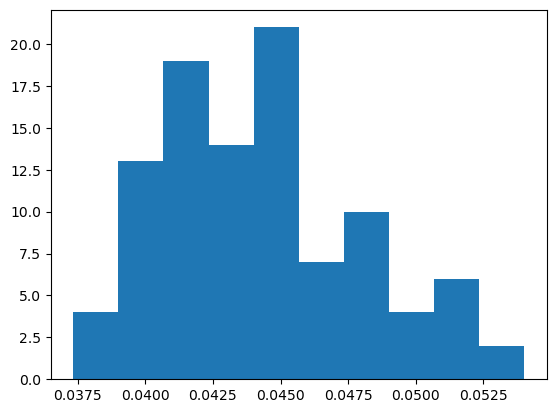

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]

0.2894736842105263


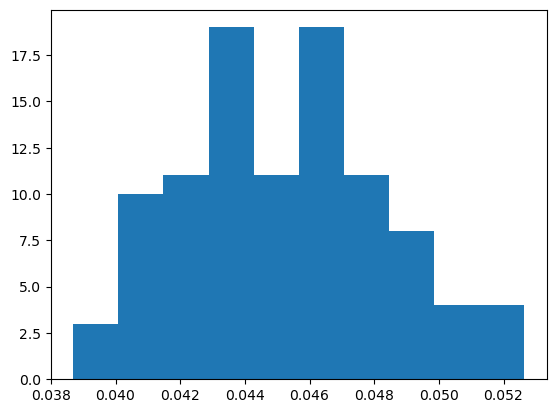

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.2421052631578947


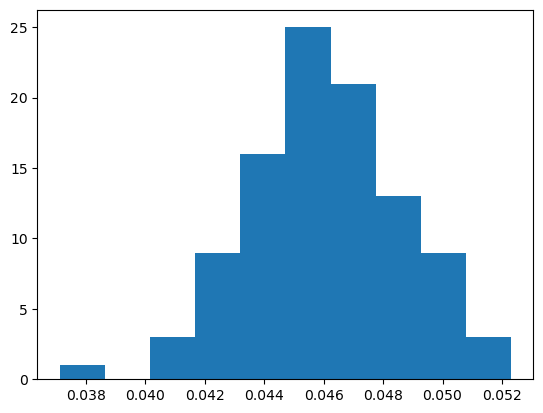

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]

0.1947368421052631


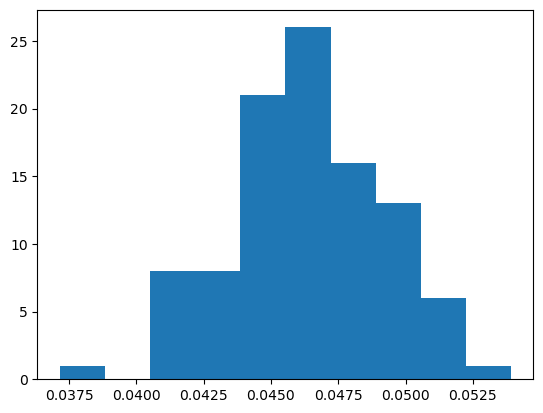

100%|██████████| 100/100 [04:28<00:00,  2.68s/it]

0.1473684210526316


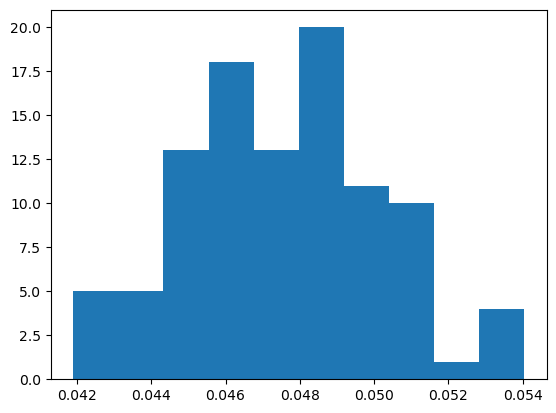

100%|██████████| 100/100 [08:05<00:00,  4.85s/it]

0.1


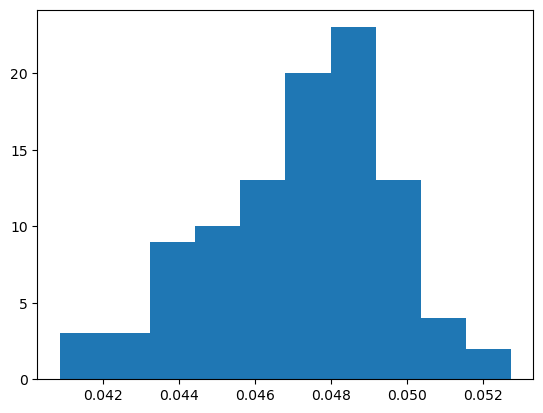

100%|██████████| 100/100 [08:42<00:00,  5.22s/it]

0.098


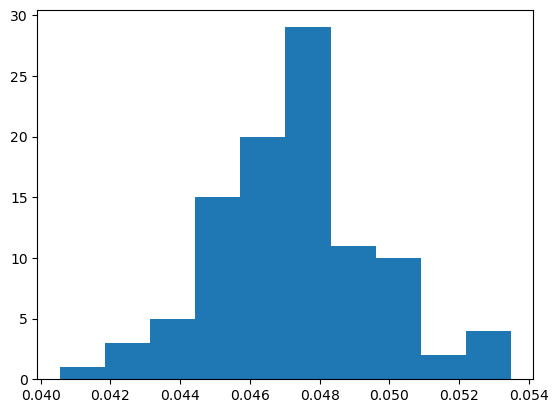

100%|██████████| 100/100 [08:59<00:00,  5.40s/it]

0.09336842105263159


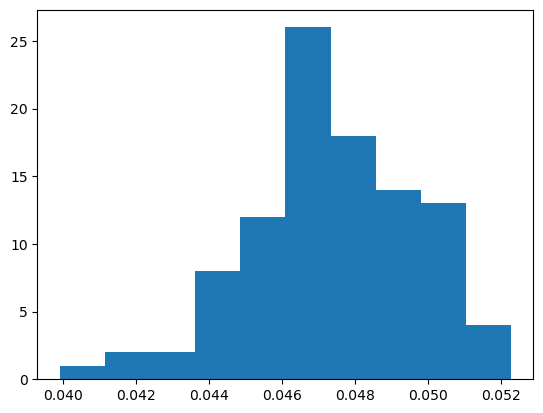

100%|██████████| 100/100 [12:19<00:00,  7.40s/it]

0.08873684210526316


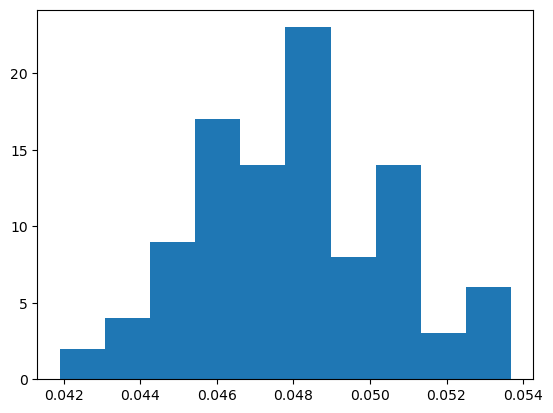

100%|██████████| 100/100 [10:14<00:00,  6.14s/it]

0.08410526315789474


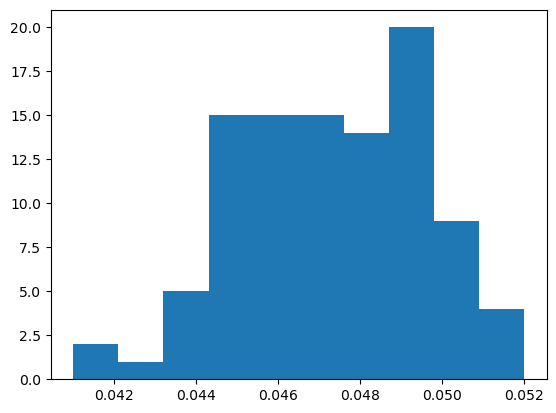

100%|██████████| 100/100 [15:15<00:00,  9.16s/it]

0.07947368421052632


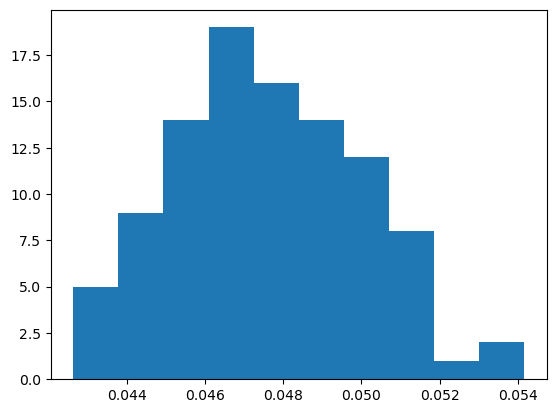

100%|██████████| 100/100 [16:55<00:00, 10.16s/it]

0.0748421052631579


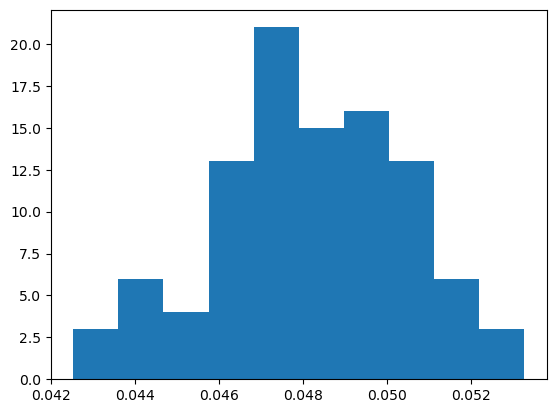

100%|██████████| 100/100 [14:34<00:00,  8.74s/it]

0.07021052631578947


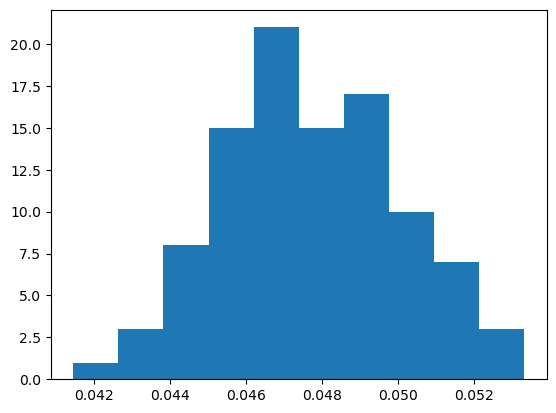

 45%|████▌     | 45/100 [08:36<10:31, 11.49s/it]

[0.048573061414334213, 0.04612934355146951, 0.046607464297565626, 0.043944735637477424, 0.0468730361230296, 0.04990146302032759, 0.04144102375803762, 0.044576728759647265, 0.0505837826950068, 0.05113154169472718, 0.04522696853263007, 0.04892846034010104, 0.04707848544368646, 0.04971182659598237, 0.05331869517107095, 0.04645009930386575, 0.05167037330856845, 0.047877582256369434, 0.049343251919213495, 0.04713614372825484, 0.049176485719682334, 0.0484764970362193, 0.04384170890093875, 0.044778332294124874, 0.04721543910743357, 0.05210759583819692, 0.04457129127917031, 0.046363896658494094, 0.05027639978458303, 0.048779173140655864, 0.04878871400058664, 0.0482545906899751, 0.051466084326698996, 0.0467640713725397, 0.04938602842281492, 0.048724592476790014, 0.04602587146879792, 0.04491601851207418, 0.05039513090622924, 0.047890250283709634, 0.04795461437598125, 0.05159737868092446, 0.04566392062966379, 0.050512797677515764, 0.04870736597116556, 0.046425434122697215, 0.04648230090964533, 0.

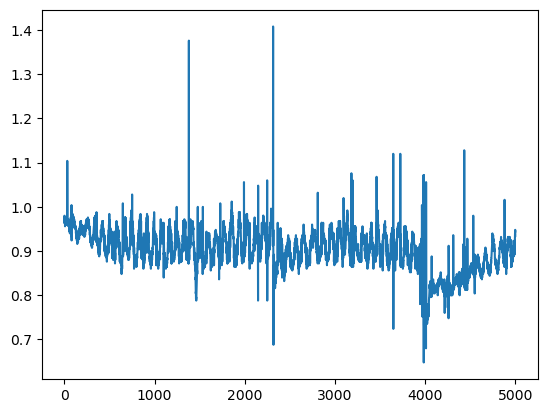

100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


1.0


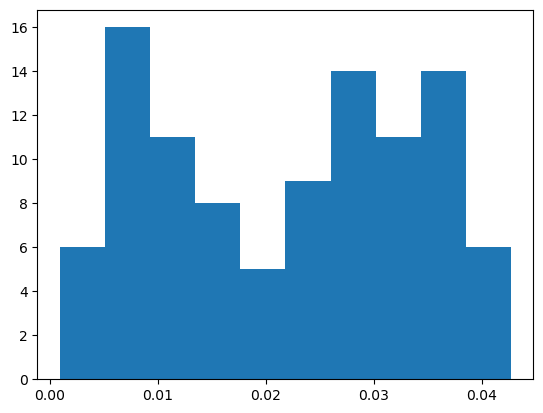

100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


0.9526315789473684


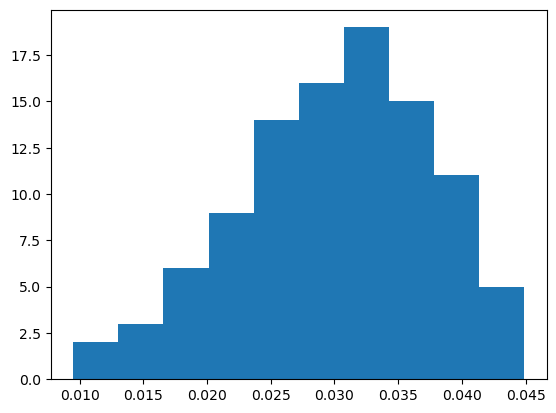

100%|██████████| 100/100 [00:17<00:00,  5.75it/s]

0.9052631578947369


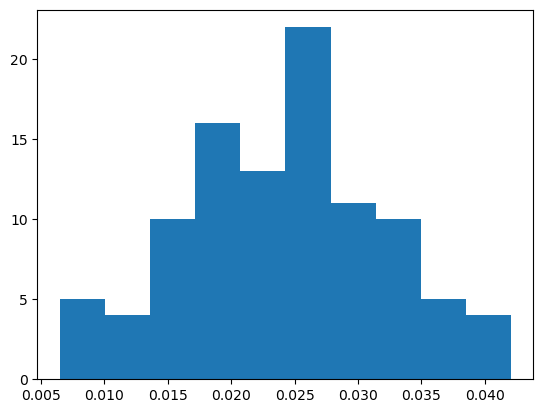

100%|██████████| 100/100 [00:29<00:00,  3.43it/s]

0.8578947368421053


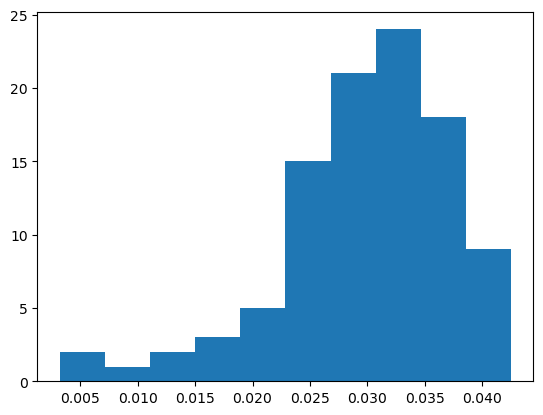

100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


0.8105263157894737


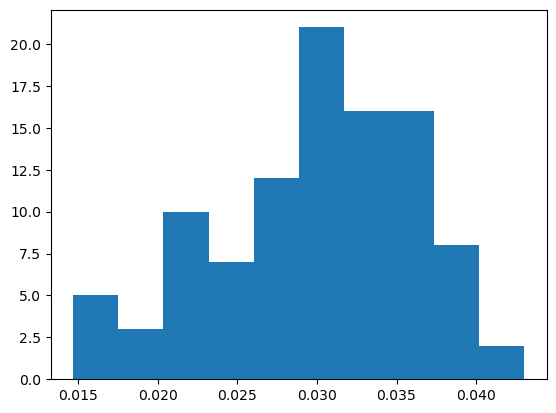

100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


0.763157894736842


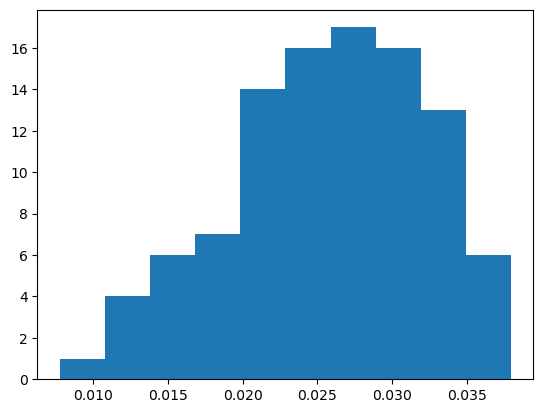

100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


0.7157894736842105


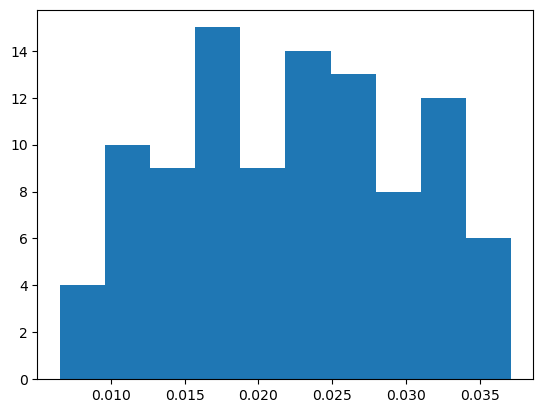

100%|██████████| 100/100 [00:22<00:00,  4.50it/s]

0.6684210526315789


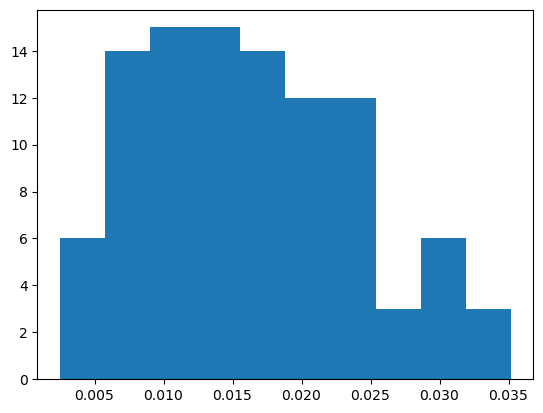

100%|██████████| 100/100 [00:24<00:00,  4.01it/s]

0.6210526315789473


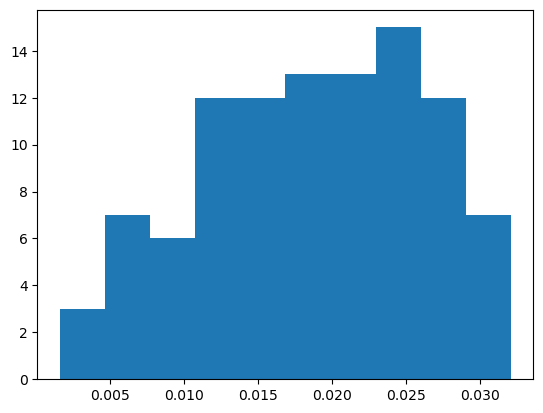

100%|██████████| 100/100 [00:28<00:00,  3.56it/s]

0.5736842105263158


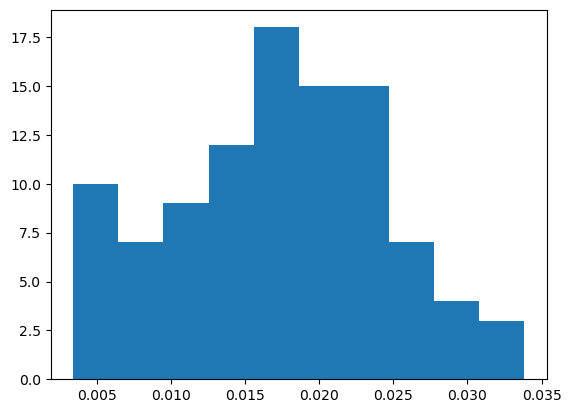

100%|██████████| 100/100 [01:00<00:00,  1.65it/s]

0.5263157894736842


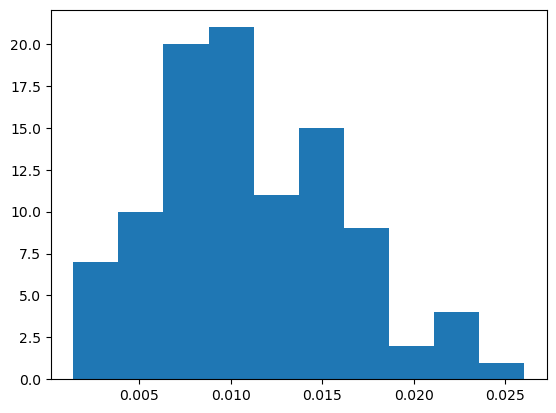

100%|██████████| 100/100 [00:45<00:00,  2.17it/s]

0.47894736842105257


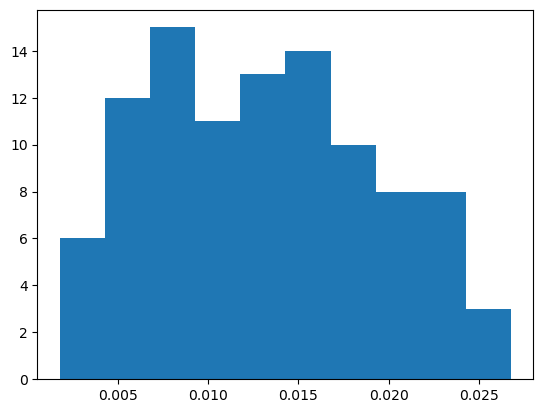

100%|██████████| 100/100 [00:54<00:00,  1.82it/s]

0.43157894736842106


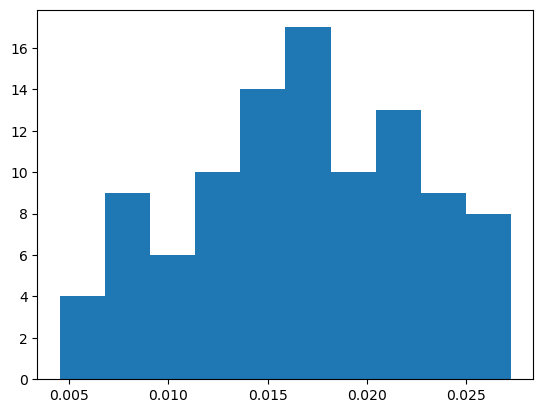

100%|██████████| 100/100 [01:27<00:00,  1.15it/s]

0.38421052631578945


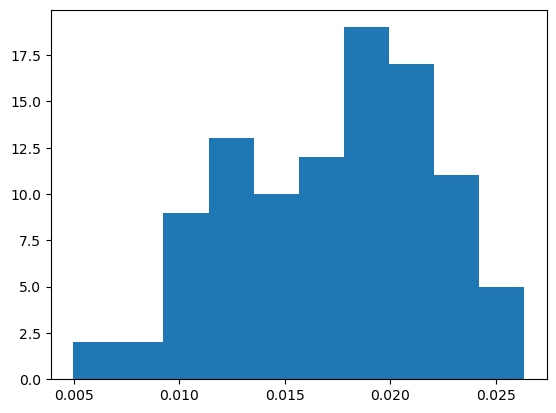

100%|██████████| 100/100 [01:50<00:00,  1.10s/it]

0.33684210526315783


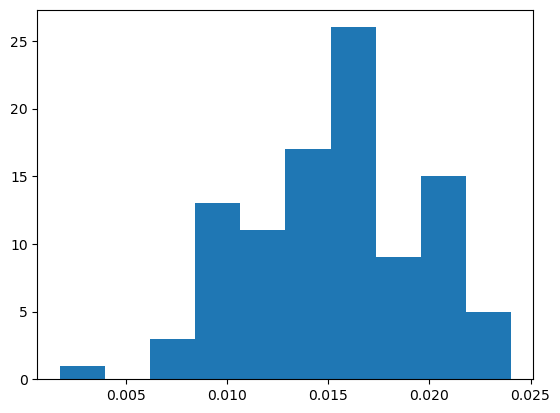

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]

0.2894736842105263


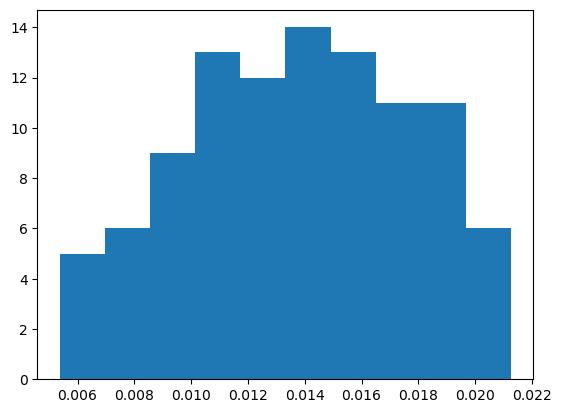

100%|██████████| 100/100 [03:49<00:00,  2.30s/it]

0.2421052631578947


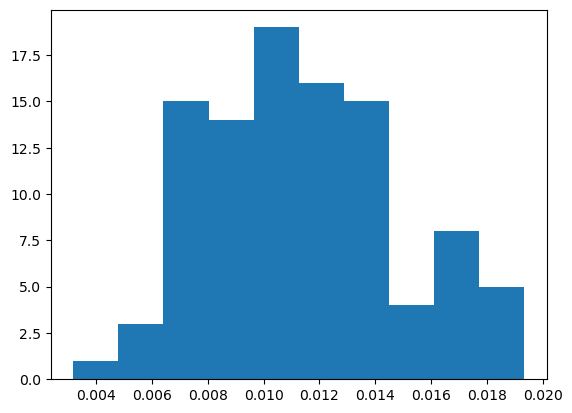

100%|██████████| 100/100 [07:34<00:00,  4.55s/it]

0.1947368421052631


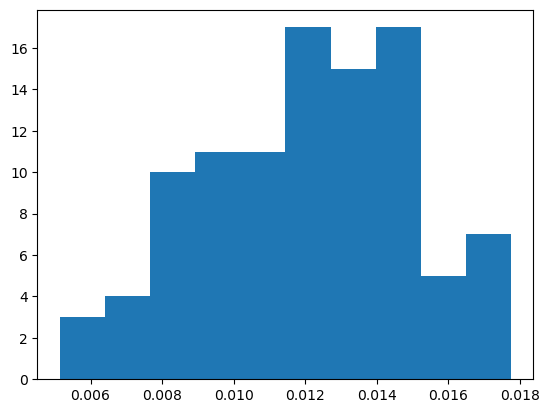

100%|██████████| 100/100 [21:23<00:00, 12.83s/it]

0.1473684210526316


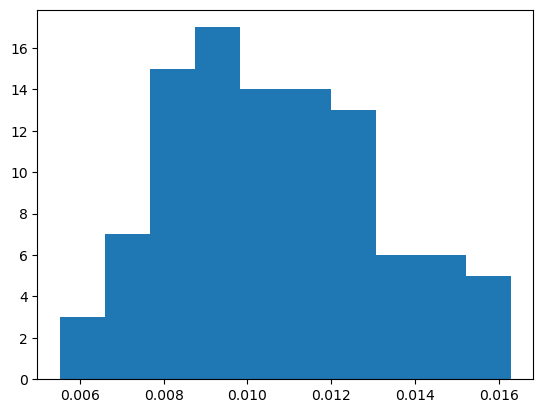

100%|██████████| 100/100 [1:38:39<00:00, 59.20s/it]

0.1


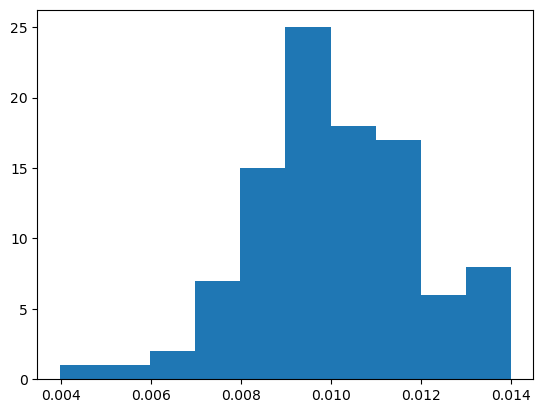

  0%|          | 0/100 [00:00<?, ?it/s]


[0.009352034660505472, 0.013037940828972869, 0.009859084338222423, 0.01305761713627434, 0.00892778559286484, 0.011587468874086765, 0.007991475511072007, 0.010489093383785461, 0.013185417653008649, 0.009616693613132523, 0.008346427831864612, 0.007265889192073794, 0.008242347267564464, 0.013031038341596583, 0.009040066614840666, 0.008573589153255866, 0.011646152066918231, 0.012870858345651158, 0.007964348694732015, 0.00980030560464925, 0.010459075675070227, 0.008165890614829127, 0.009653059388815003, 0.011304504099108251, 0.01089078462621401, 0.008964274414092336, 0.0062737430676729974, 0.011049733942366621, 0.011390206800962048, 0.01058240174994138, 0.00824435246238514, 0.012882773713307222, 0.009951867676155145, 0.00593774563410049, 0.00803450144788072, 0.009444221960738635, 0.009110183357604742, 0.009386146439889288, 0.012399792611323306, 0.010551868661565664, 0.01166203214566808, 0.010396121961925086, 0.013223594503661744, 0.009561004878322213, 0.010911332502716182, 0.010612615647077

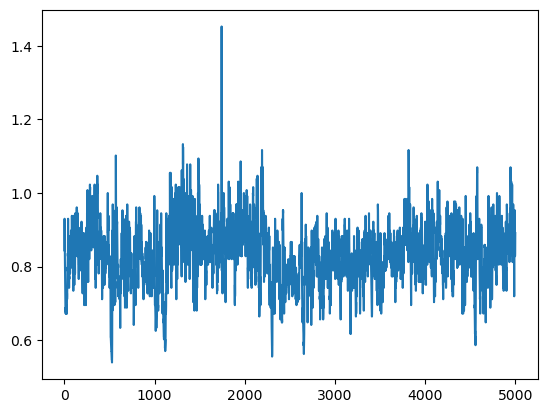

100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


1.0


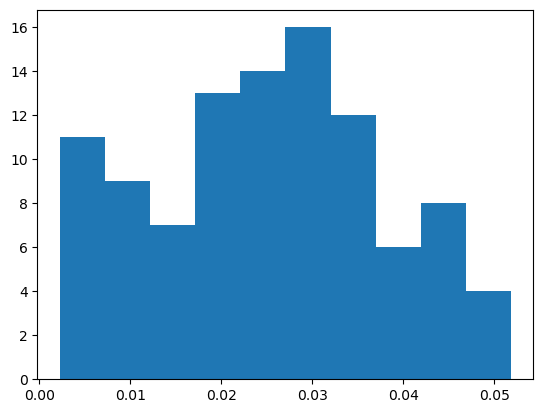

100%|██████████| 100/100 [00:17<00:00,  5.78it/s]

0.9526315789473684


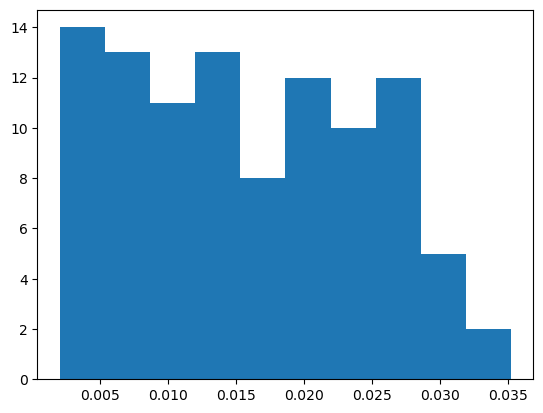

100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


0.9052631578947369


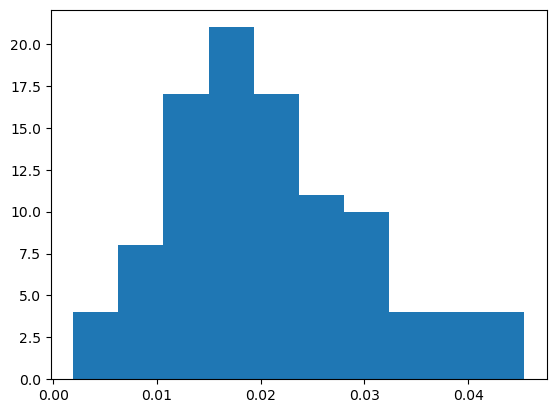

100%|██████████| 100/100 [00:22<00:00,  4.41it/s]

0.8578947368421053


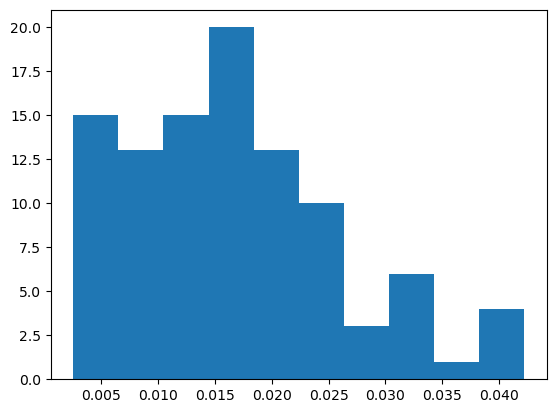

100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


0.8105263157894737


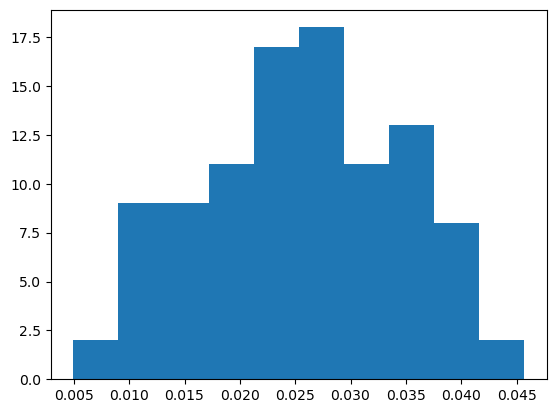

100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


0.763157894736842


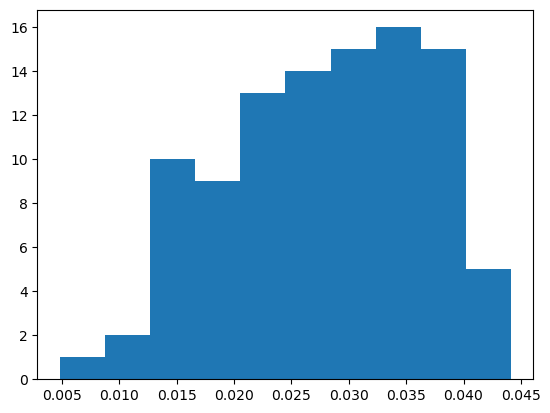

100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


0.7157894736842105


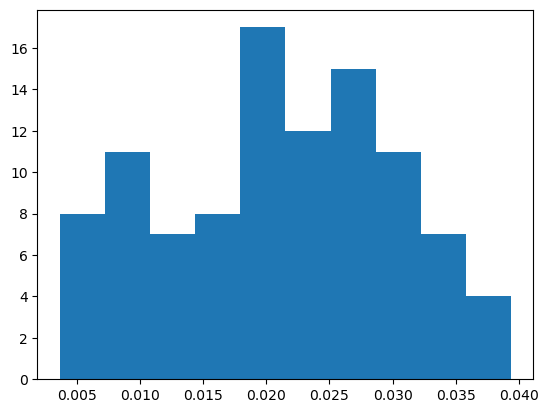

100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


0.6684210526315789


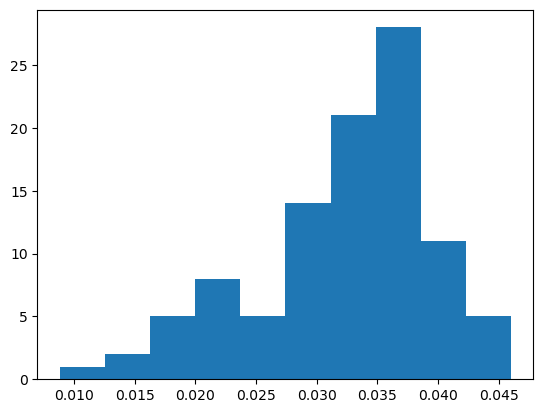

100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


0.6210526315789473


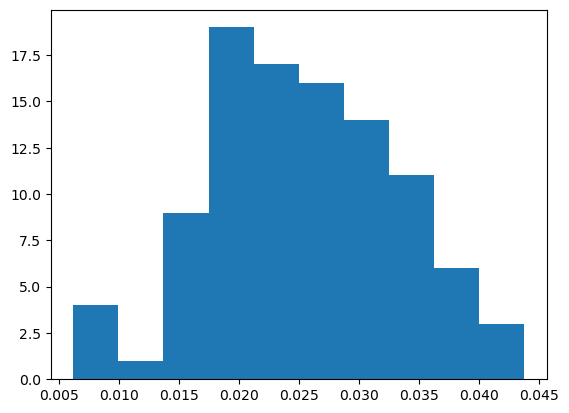

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]

0.5736842105263158


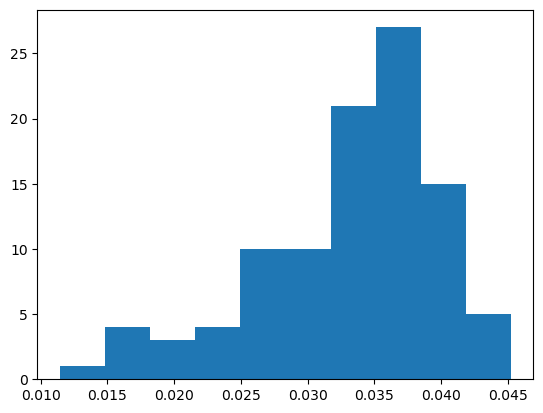

100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


0.5263157894736842


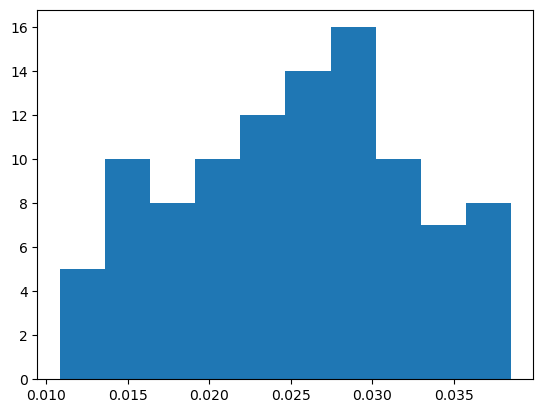

100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


0.47894736842105257


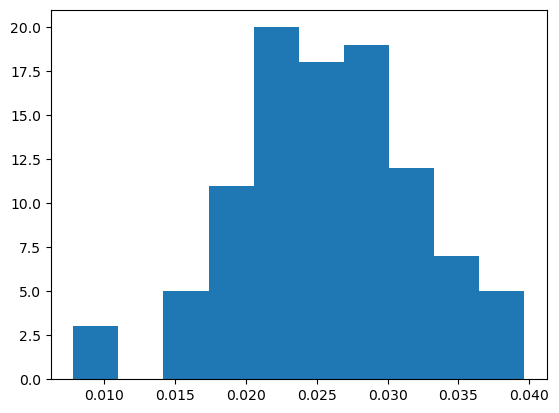

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


0.43157894736842106


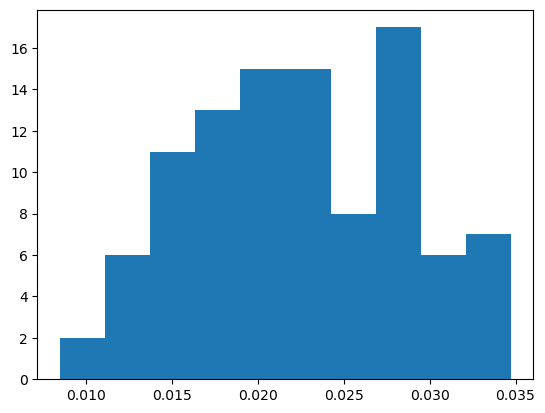

100%|██████████| 100/100 [00:57<00:00,  1.74it/s]

0.38421052631578945


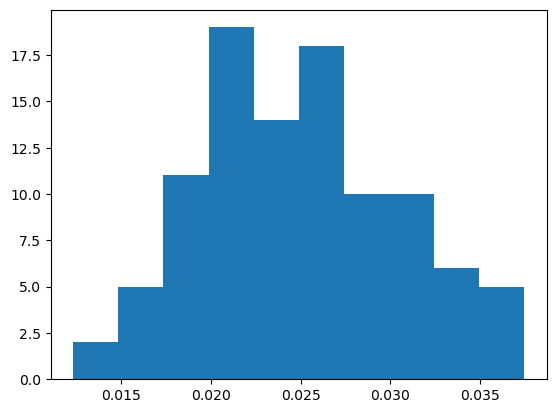

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]

0.33684210526315783


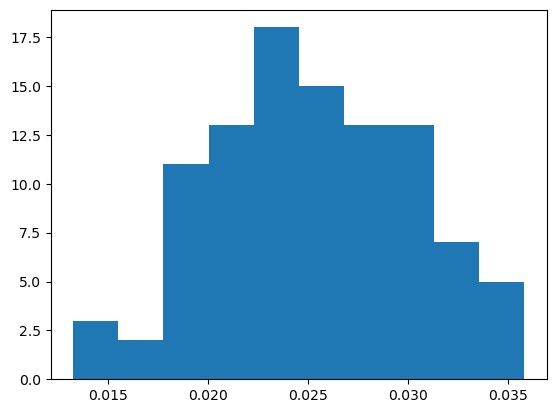

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]

0.2894736842105263


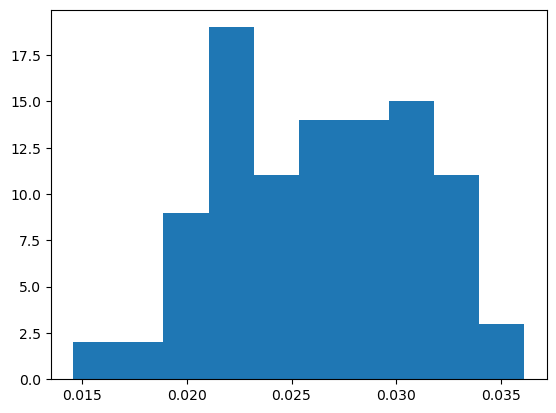

100%|██████████| 100/100 [02:23<00:00,  1.44s/it]

0.2421052631578947


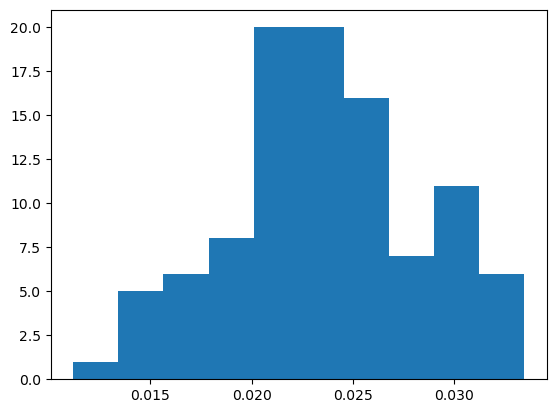

100%|██████████| 100/100 [04:55<00:00,  2.95s/it]

0.1947368421052631


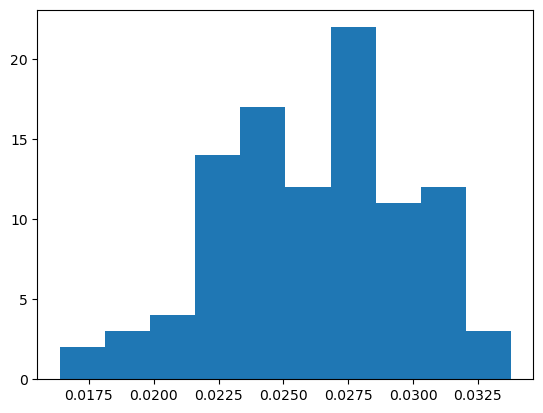

100%|██████████| 100/100 [10:12<00:00,  6.13s/it]

0.1473684210526316


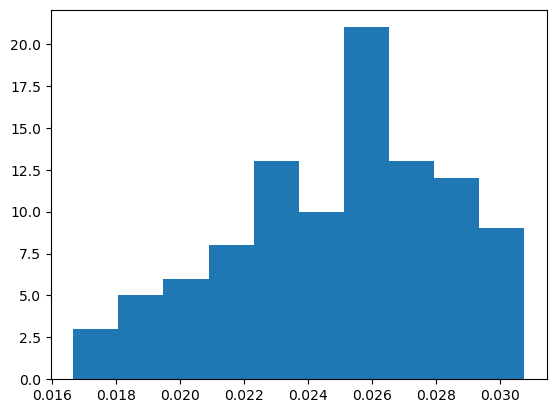

100%|██████████| 100/100 [26:33<00:00, 15.93s/it]

0.1


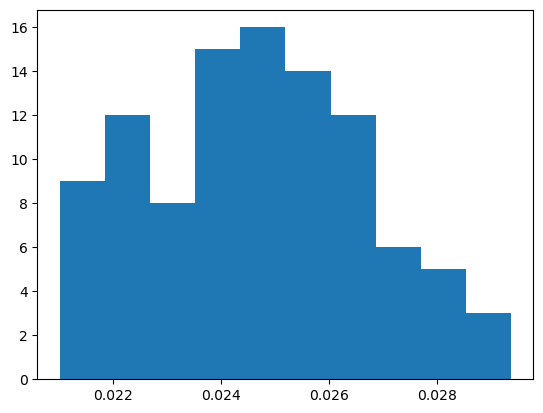

100%|██████████| 100/100 [28:30<00:00, 17.10s/it]

0.098


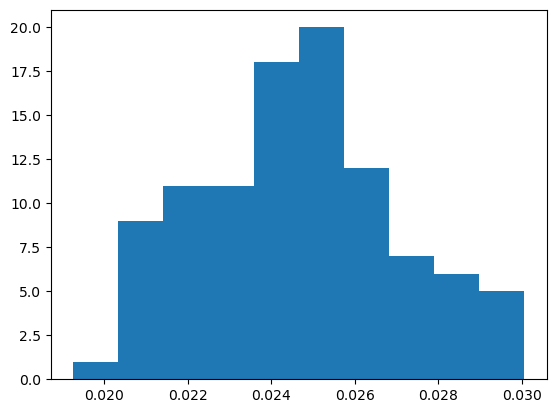

100%|██████████| 100/100 [34:10<00:00, 20.51s/it]

0.09336842105263159


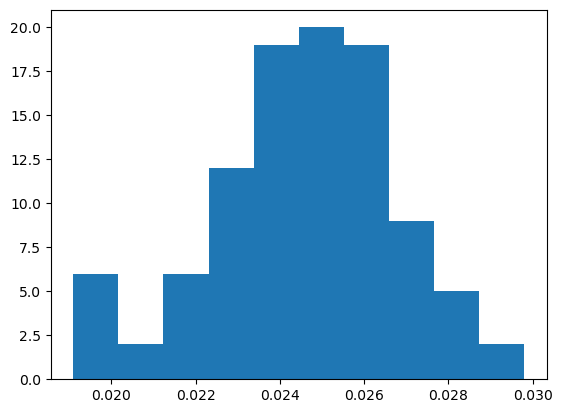

  2%|▏         | 2/100 [3:54:28<191:28:52, 7034.01s/it]

[0.026635683594618476, 0.027048003350318525, 0.02320673780619677, 0.02465525841306634, 0.026741913435522974, 0.022563726782144855, 0.025577565530064926, 0.0194577799942176, 0.029796831652828207, 0.02781257953200658, 0.02447255796107796, 0.02634182206064357, 0.02526931982186266, 0.026100382182867223, 0.0259895401431518, 0.023294885981155335, 0.022102287863538732, 0.024325965524037926, 0.024193079314141372, 0.025718629982532625, 0.02640009802988169, 0.024665180145866317, 0.023832207330242834, 0.0264483132656861, 0.02399612680390245, 0.0228567338416449, 0.02398080655164404, 0.021038927093160784, 0.025302169018309777, 0.02384300072067162, 0.02548553064460725, 0.024490802688358817, 0.021511082057702375, 0.023779155072309655, 0.019304592534667306, 0.021358712884432123, 0.02331051106427652, 0.02818588755356038, 0.023400042575515263, 0.019356798869445715, 0.021998653261465505, 0.02309246359734809, 0.024659157709245864, 0.01998913369372871, 0.024892283354668084, 0.026435038009210102, 0.02578603

In [45]:
subjects = ["a5nn", "c2nn", "n1nn"] # Subject to be estimated

results = []

for subject in subjects:

    # Load data
    n = get_beats(subject, abnormal=True)
    data = n[65000:70000]

    # Plot data
    plt.plot(data)
    plt.show()

    start_time = time.time()

    t = 0
    result = []
    theta_result = []

    # ABC SMC
    for thresh in thresholds:
        result = ABC_SMC_Ivanov(data, 100, thresh, t, result, start_time)
        t += 1        

        if len(result)==0:
            results.append(theta_result)
            break
            

        theta_result = []
        
        for j in range(len(result)):
            theta_result.append(result[j][0])

        
        # Plot iteration estimations
        print(thresh)
        plt.hist(theta_result)
        plt.show()

    # Print final estimations
    print(theta_result)

Mean:  0.010925192351513957


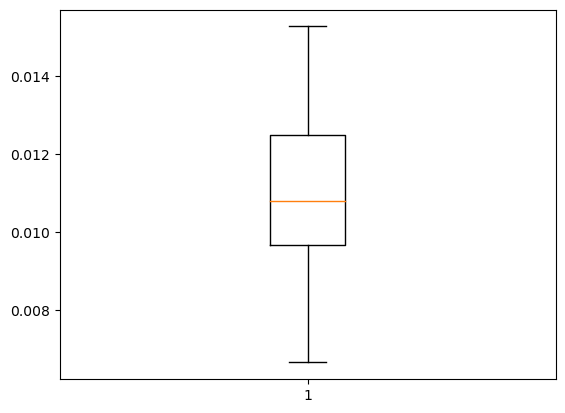

In [28]:
r = results[4]
print("Mean: ", np.mean(r))
plt.boxplot(r)
plt.show()

### Test
Performs a few tests to check that the method works. This is done by generating time series with the Ivanov model with known parameters value and try to estimate these parameters.

In [79]:
num_trials = 3 # Number of estimations for one parameter value
parameters_test = [0.005, 0.01, 0.025, 0.05, 0.075] # Parameters value of the Ivanov model to be tested

is_random = False # If True, the parameter value is selected randomly

trials1 = []
trials2 = []
trials3 = []

labels = []

for w in parameters_test:

    # Select parameter value
    if is_random:
        w_x = random.uniform(0, 0.1)
    else:
        w_x = w

    for i in range(num_trials):
        
        # Generate data
        data = fm.IvanovModel(w_SA=0, w_SS=w_x, w_PS=0, Num_beats=5000, N=10)

        t = 0
        result = []
        final_result = []

        start_time = time.time()

        # ABC SMC
        for thresh in thresholds:
            
            result = ABC_SMC_Ivanov(data, 100, thresh, t, result, start_time)
            t += 1

            theta_result = []

            for j in range(len(result)):
                theta_result.append(result[j][0])

            if len(result) != 0:
                final_result = theta_result
            else:
                break

            if time.time() - start_time > 3600:
                break

        plt.hist(final_result)
        plt.xlabel(r"$w_{SS}^*$")
        plt.ylabel("Number of particles")
        plt.title(r"$w_{SS}=$" + str(w_x))
        plt.show()

        print("w_SS = ", w_x)
        print("Mean: ", np.mean(np.array(final_result)))
        print("Standard deviation: ", np.std(np.array(final_result)))

        if i==0:
            trials1.append(final_result)
        elif i==1:
            trials2.append(final_result)
        else:
            trials3.append(final_result)

    labels.append(w_x)

 90%|█████████ | 90/100 [00:22<00:02,  4.00it/s]


KeyboardInterrupt: 

## Ivanov 2 parameters estimation
In this section, the estimation of the two parameters $w_{PS}$ and $w_{SS}$ of the Ivanov model is performed. This is done by ignoring the effect of $I_{SA}$. The parameteres selected for the estimation can easily be changed by modifying the method ABC_SMC_Ivanov_2.

In [ ]:
def theta_dist(t=0, previous_theta=[]):
    """
    Selecting the parameter value to be considered

    Arguments:
    - t: the iteration at which we are in the ABC SMC. If it is 0, the parameter
            value is selected from the prior distribution (uniform). Otherwise
            it is selected based on the previous estimation of the posterior
            distribution (more details on the selecting process available at
            https://www.nature.com/articles/npre.2011.5964.1)

    - previous_theta: list of the previous accepted estimations of the parameter
                        theta. It is a list of lists of size 2 with the first 
                        element being the value of the parameter and the second
                        being the weight of that parameter.

    Returns:
    - the new estimation of the parameter theta
    - the temporary weight (need to be normalized) of that parameter
    """
    # First iteration, use of the prior distribution
    if t == 0:
        return np.random.uniform(0, 0.1), 1
    
    # Draw theta* from the previous estimations
    sample = np.random.uniform(0, 1)
    theta_sample = previous_theta[0][0]
    cnt = 0

    for i in range(len(previous_theta)):
        cnt += previous_theta[i][1]
        if sample > cnt:
            theta_sample = previous_theta[i][0]
            break

    # Perturb with the kernel
    theta = theta_sample + np.random.normal(0, 0.01)

    # Compute the weight of the estimation
    pi_theta = 1/0.1
    sum_deno = 0

    for i in range(len(previous_theta)):
        diff = theta - previous_theta[i][0]
        sum_deno += previous_theta[i][1] * norm.pdf(diff, 0, 0.01)

    w = pi_theta/sum_deno

    return theta, w
    


def ABC_SMC_Ivanov_2(Observed_data, Number_of_Samples, threshold, t, previous_theta1=[], previous_theta2=[], start_time2=0):
    """
    Computes the estimation using ABC SMC of the parameter theta for given
    observation. This method estimates two parameters of the Ivanov model

    Arguments:
    - Observed_data: the observed time series from which we want to estimate
                        the parameters
    - Number_of_Samples: the number of estimations for the parameter theta
    - treshold: the value under which the distance between the observed data
                and the signal generated with the parameter estimation must
                be under
    - t: the iteration at which the estimation is
    - previous_theta: the parameters estimations made at the previous iteration.
                        It is a list of lists of size 2 with the first element 
                        being the value of the parameter and the second being 
                        the weight of that parameter.
    - start_time: the time at which the first iteration was launched (used to 
                    stop the process if it is running for too much time)

    Returns:
    - The new parameters estimations. It is a list of lists of size 2 with the first 
        element being the value of the parameter and the second being the weight of 
        that parameter.

    """

    #initialise Posterior array
    Posterior_distribution1 = []
    Posterior_distribution2 = []


    norm_factor1 = 0
    norm_factor2 = 0

    #loop through to get the samples. 
    for i in tqdm(range(Number_of_Samples)):
        distance = threshold+1
        #While the distance is greater than the threshold continue to sample theta from the beta distribution
        while distance > threshold:
            if time.time() - start_time2 > 18000 and i < Number_of_Samples - Number_of_Samples/5:
                return [], []
            #sample theta from the prior
            theta1, w1 = theta_dist(t, previous_theta1)
            theta2, w2 = theta_dist(t, previous_theta2)
            # generate the sim data 
            X = fm.IvanovModel(w_SA=0, w_SS=theta2, w_PS=theta1, Num_beats=5000)
            # calcalute the distance from Y 
            distance = distance_function(X,Observed_data)

        Posterior_distribution1.append([theta1, w1])
        norm_factor1 += w1

        Posterior_distribution2.append([theta2, w2])
        norm_factor2 += w2

    # Normalize weights
    for i in range(len(Posterior_distribution1)):
        Posterior_distribution1[i][1] /= norm_factor1

    for i in range(len(Posterior_distribution2)):
        Posterior_distribution2[i][1] /= norm_factor2

    return Posterior_distribution1, Posterior_distribution2

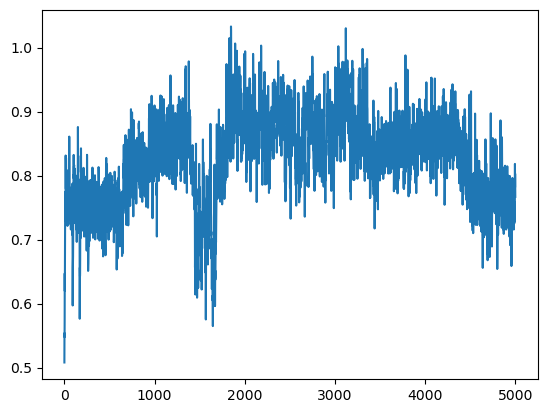

100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


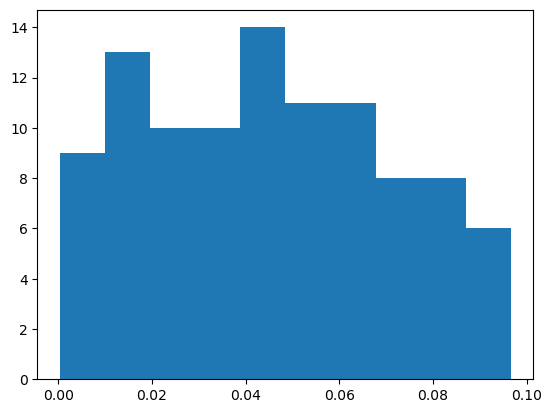

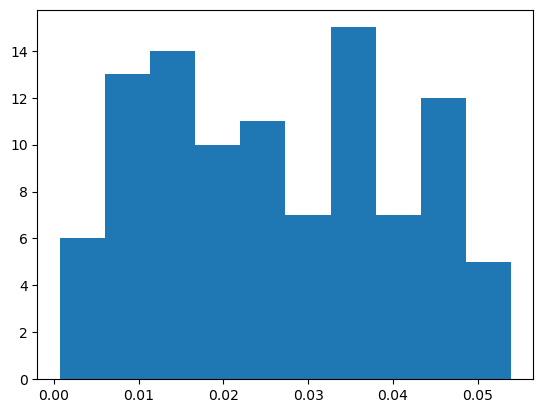

100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


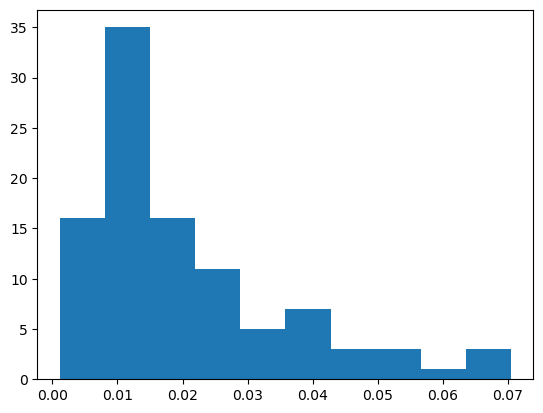

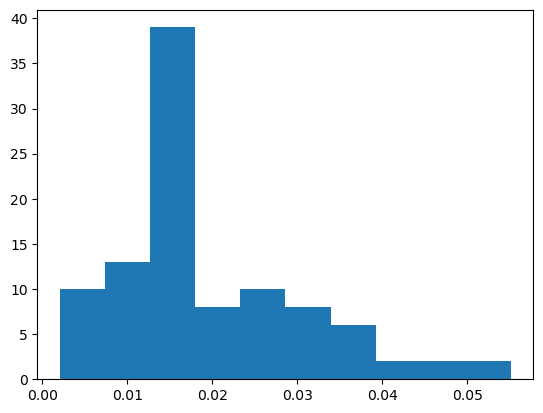

100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


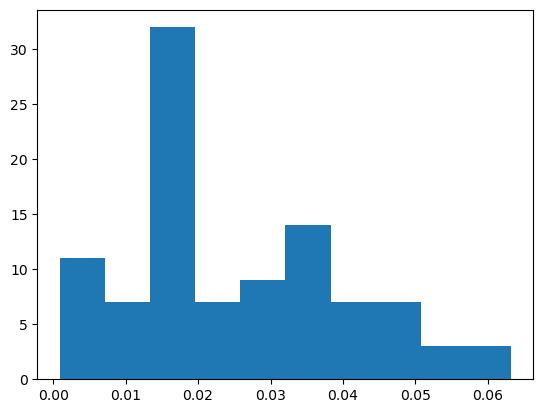

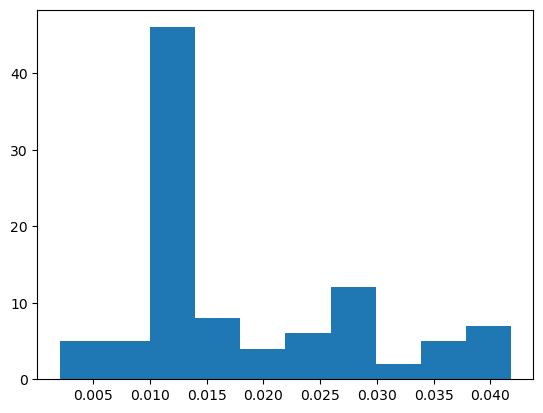

100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


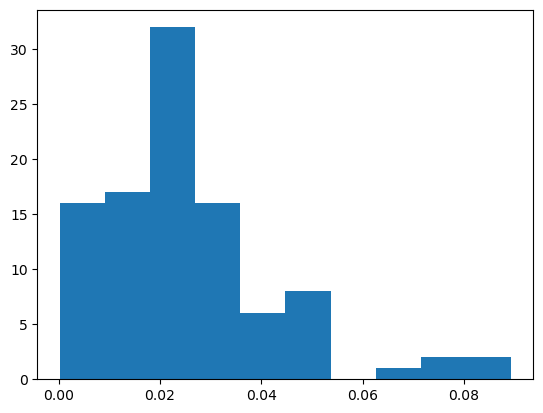

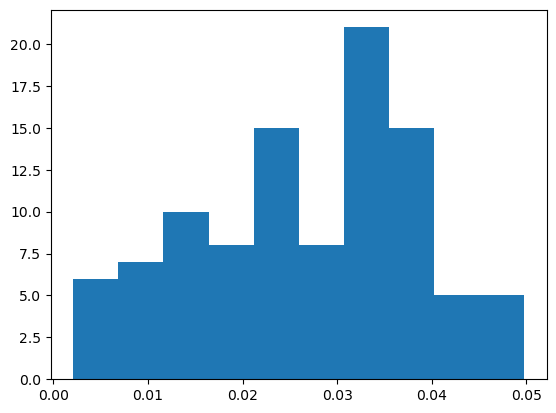

100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


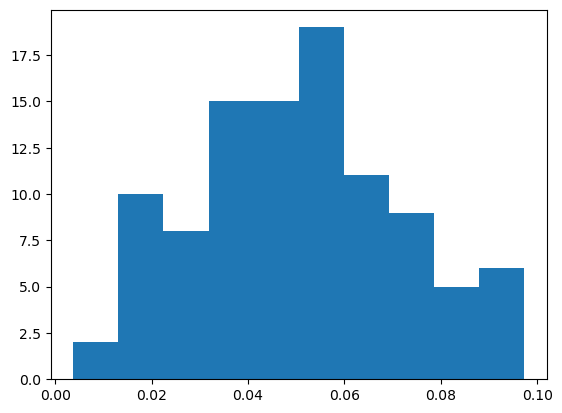

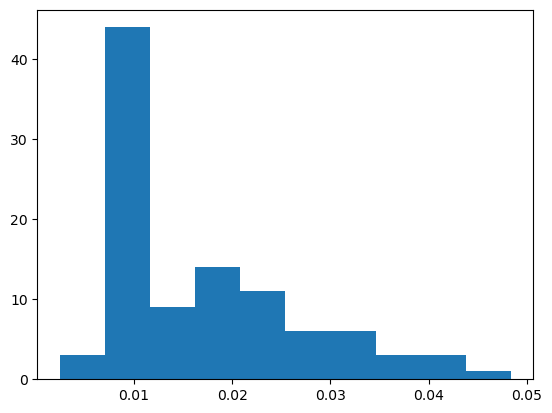

100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


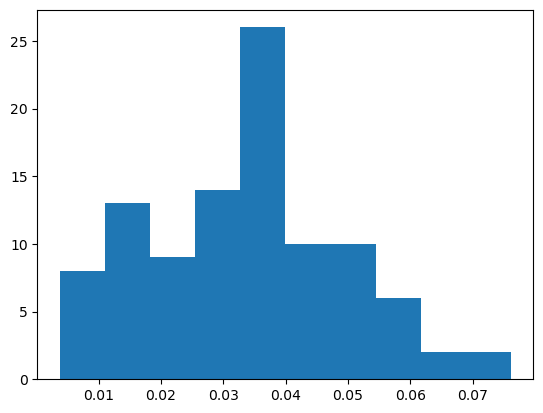

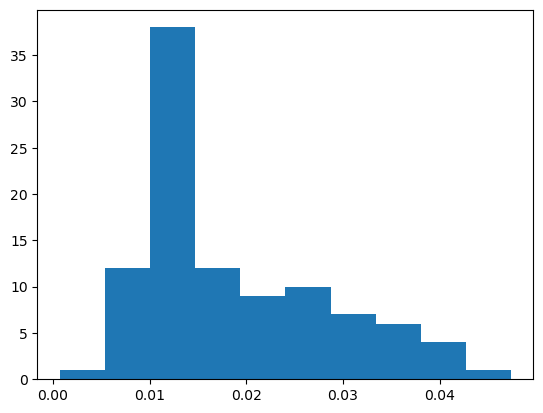

100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


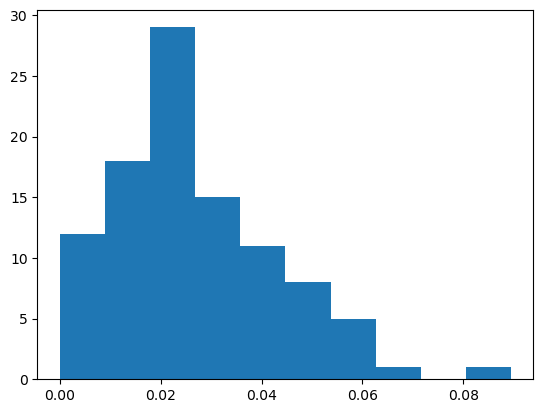

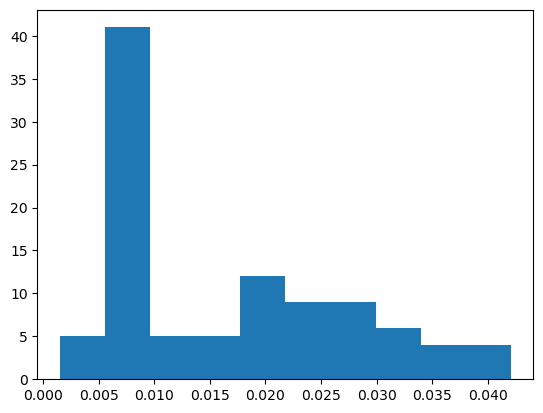

100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


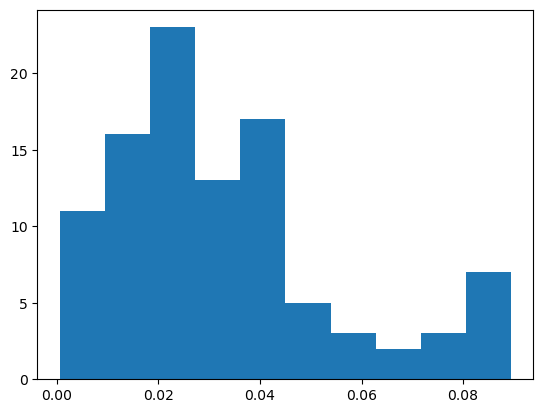

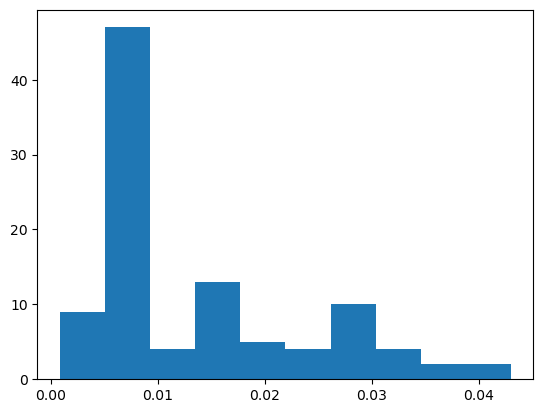

100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


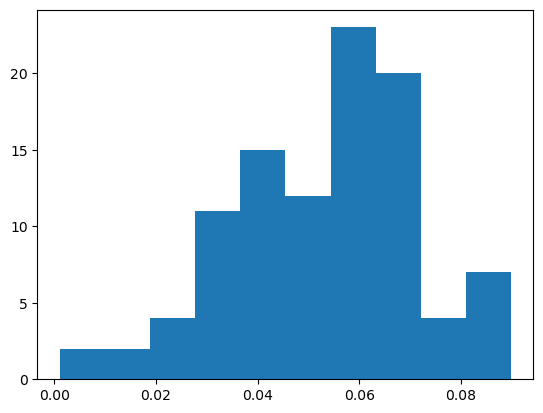

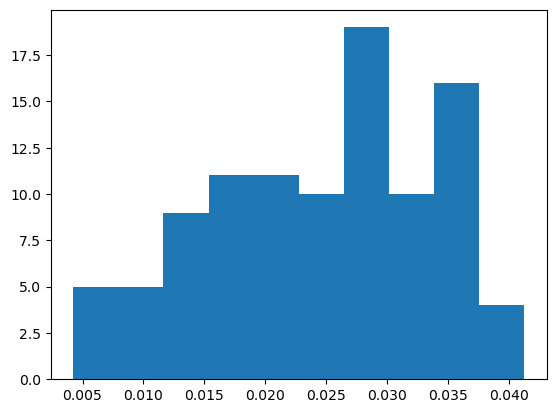

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


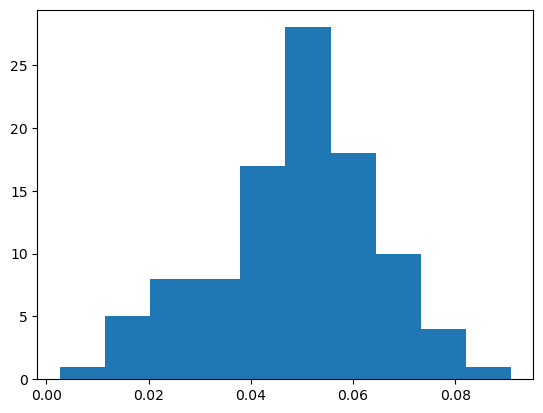

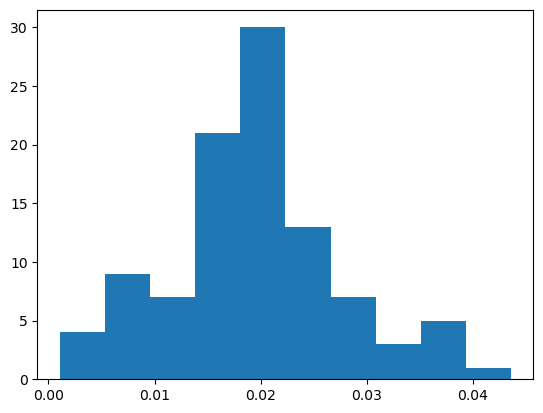

100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


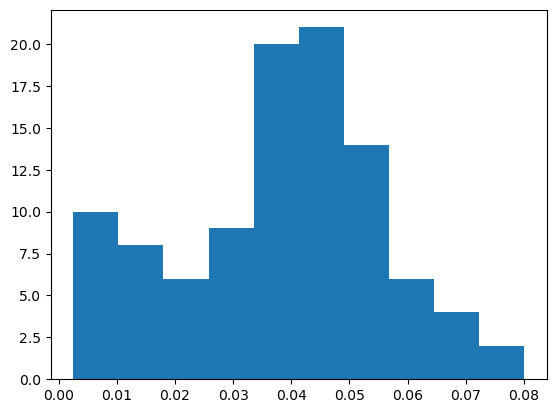

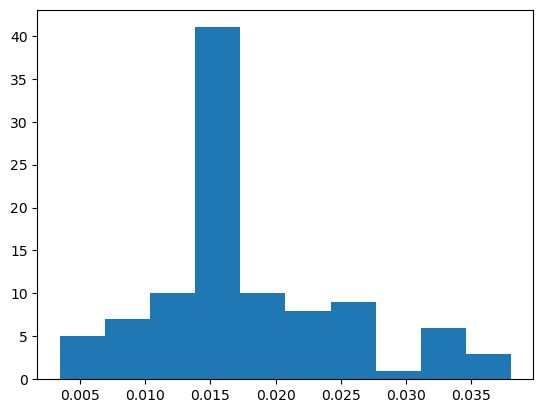

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


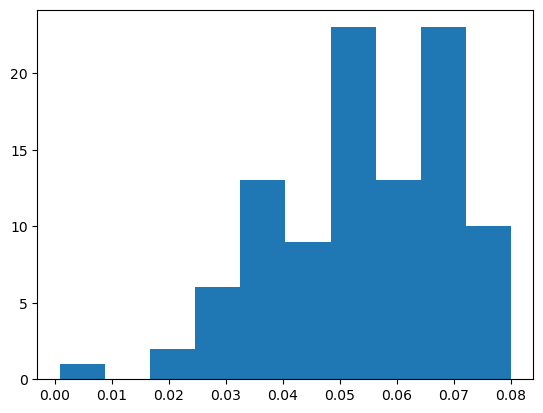

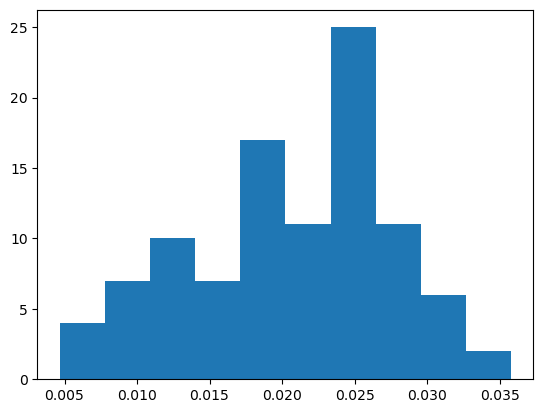

100%|██████████| 100/100 [03:40<00:00,  2.21s/it]


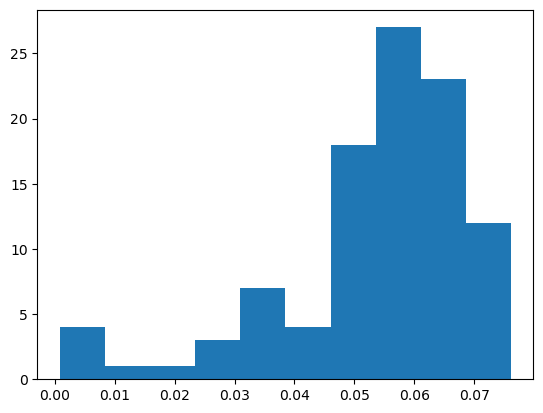

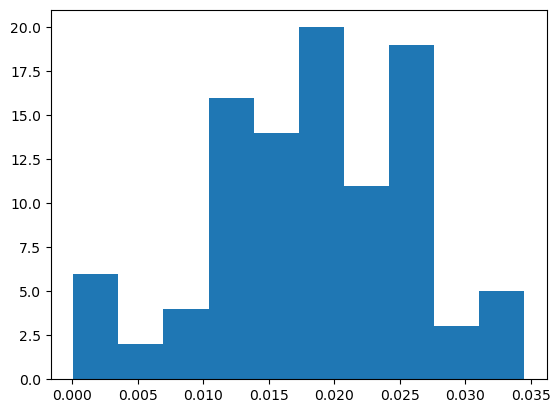

100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


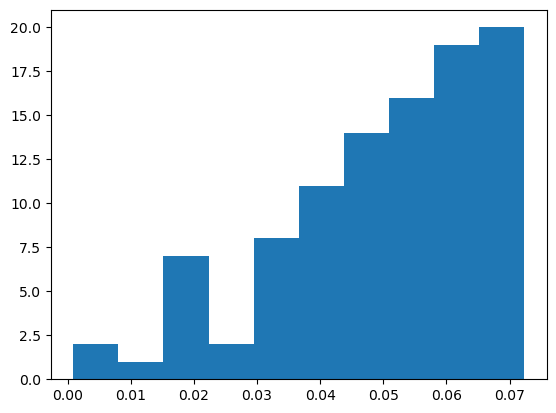

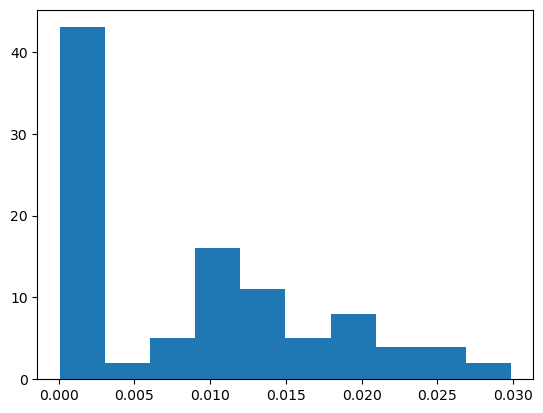

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


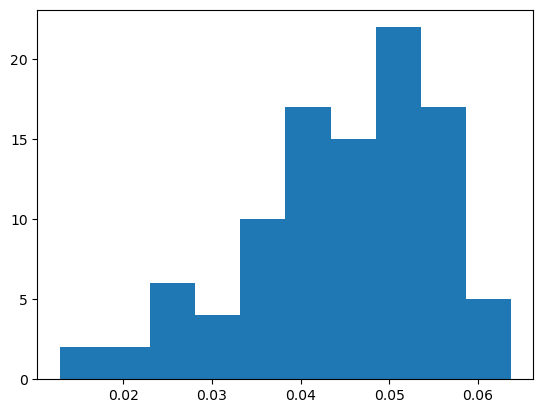

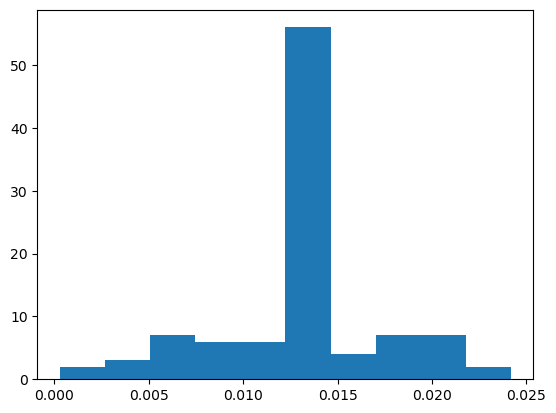

100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


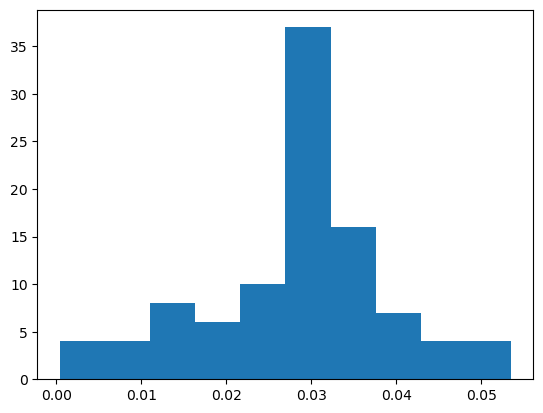

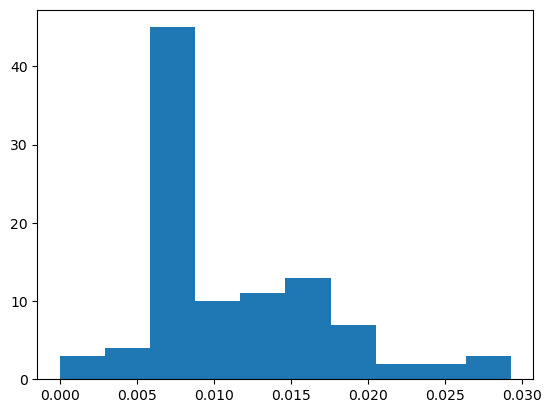

100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


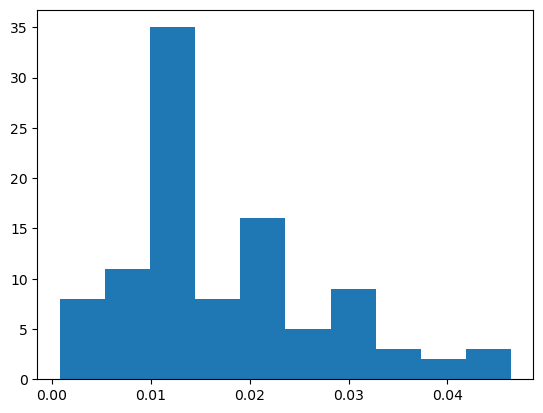

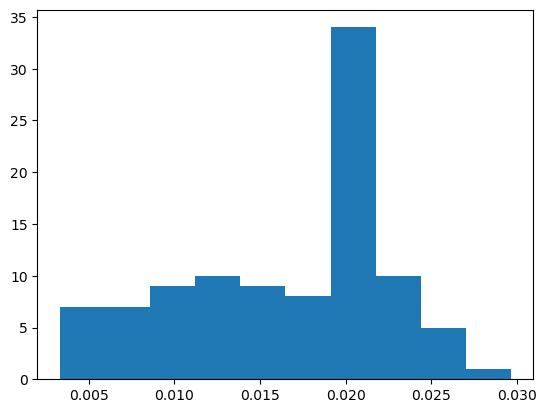

100%|██████████| 100/100 [05:41<00:00,  3.42s/it]


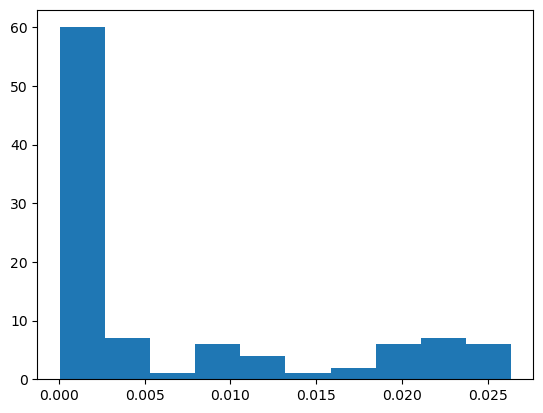

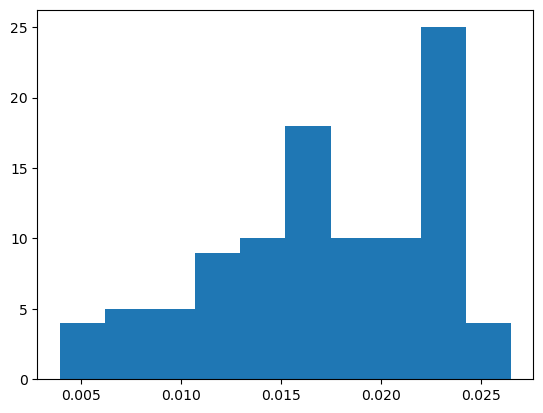

100%|██████████| 100/100 [08:43<00:00,  5.23s/it]


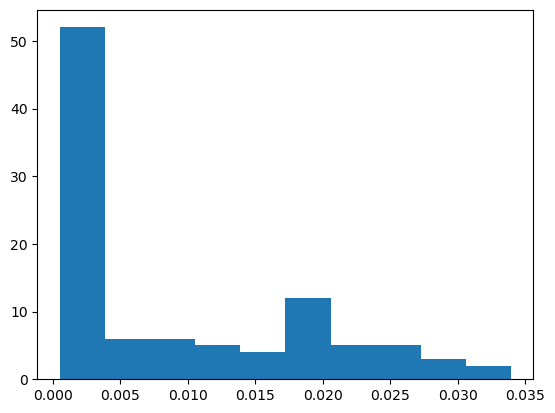

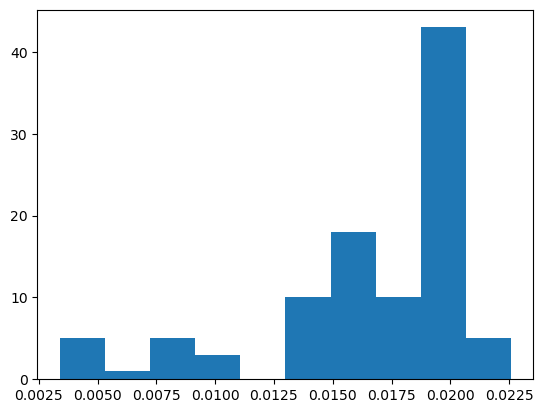

100%|██████████| 100/100 [13:33<00:00,  8.14s/it]


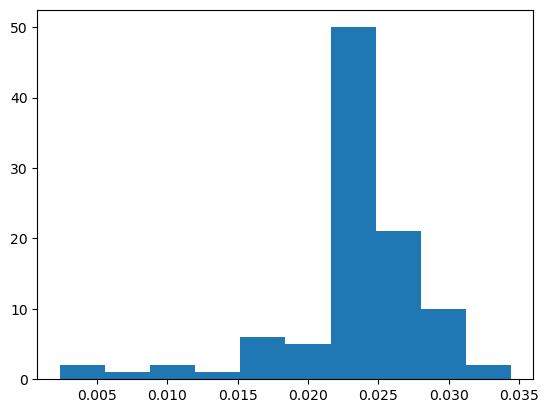

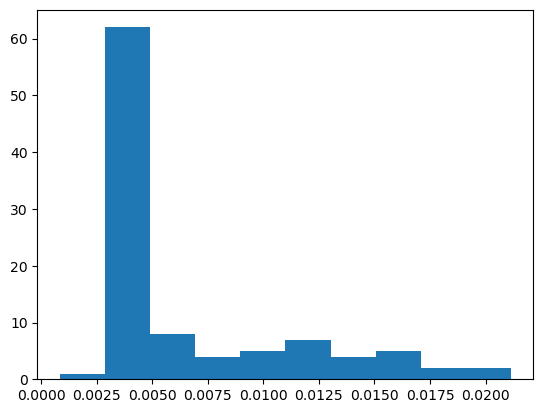

100%|██████████| 100/100 [14:00<00:00,  8.41s/it]


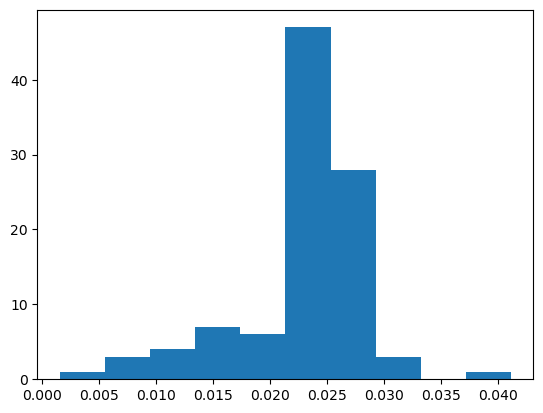

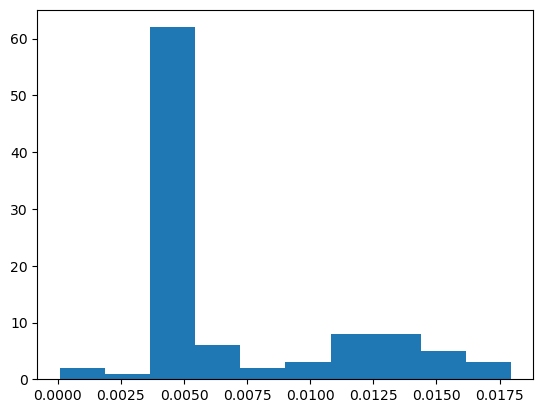

  6%|▌         | 6/100 [00:54<14:09,  9.04s/it]


KeyboardInterrupt: 

In [ ]:
# Generate data
data = fm.IvanovModel(w_SA=0, w_SS=0.01, w_PS=0.03, Num_beats=5000, std_eta=math.sqrt(2)*0.5)

plt.plot(data)
plt.show()


thresholds1 = np.linspace(1, 0.1, 20)
thresholds2 = np.linspace(0.098, 0.01, 20)
thresholds3 = np.linspace(0.0098, 0.005, 20)
thresholds = np.concatenate((thresholds1, thresholds2, thresholds2))
t = 0
result1 = []
result2 = []

start_time = time.time()

# ABC SMC
for thresh in thresholds:
    result1, result2 = ABC_SMC_Ivanov_2(data, 100, thresh, t, result1, result2, start_time)
    t += 1

    theta_result1 = []
    theta_result2 = []

    for j in range(len(result1)):
        theta_result1.append(result1[j][0])

    for j in range(len(result2)):
        theta_result2.append(result2[j][0])

    if(len(result1)==0):
        break

    # Plot the iteration estimations
    plt.hist(theta_result1)
    plt.show()

    plt.hist(theta_result2)
    plt.show()

## Ivanov 3 parameters estimation
In this section, the three parameters are estimated.

In [ ]:
def theta_dist(t=0, previous_theta=[]):
    """
    Selecting the parameter value to be considered

    Arguments:
    - t: the iteration at which we are in the ABC SMC. If it is 0, the parameter
            value is selected from the prior distribution (uniform). Otherwise
            it is selected based on the previous estimation of the posterior
            distribution (more details on the selecting process available at
            https://www.nature.com/articles/npre.2011.5964.1)

    - previous_theta: list of the previous accepted estimations of the parameter
                        theta. It is a list of lists of size 2 with the first 
                        element being the value of the parameter and the second
                        being the weight of that parameter.

    Returns:
    - the new estimation of the parameter theta
    - the temporary weight (need to be normalized) of that parameter
    """
    # First iteration, use of the prior distribution
    if t == 0:
        return np.random.uniform(0, 0.1), 1
    
    # Draw theta* from the previous estimations
    sample = np.random.uniform(0, 1)
    theta_sample = previous_theta[0][0]
    cnt = 0

    for i in range(len(previous_theta)):
        cnt += previous_theta[i][1]
        if sample > cnt:
            theta_sample = previous_theta[i][0]
            break

    # Perturb with the kernel
    theta = theta_sample + np.random.normal(0, 0.01)

    # Compute the weight of the estimation
    pi_theta = 1/0.1
    sum_deno = 0

    for i in range(len(previous_theta)):
        diff = theta - previous_theta[i][0]
        sum_deno += previous_theta[i][1] * norm.pdf(diff, 0, 0.01)

    w = pi_theta/sum_deno

    return theta, w
    


def ABC_SMC_Ivanov_3(Observed_data, Number_of_Samples, threshold, t, previous_theta1=[], previous_theta2=[], previous_theta3=[], start_time2=0):
    """
    Computes the estimation using ABC SMC of the parameter theta for given
    observation. This method estimates three parameters of the Ivanov model

    Arguments:
    - Observed_data: the observed time series from which we want to estimate
                        the parameters
    - Number_of_Samples: the number of estimations for the parameter theta
    - treshold: the value under which the distance between the observed data
                and the signal generated with the parameter estimation must
                be under
    - t: the iteration at which the estimation is
    - previous_theta: the parameters estimations made at the previous iteration.
                        It is a list of lists of size 2 with the first element 
                        being the value of the parameter and the second being 
                        the weight of that parameter.
    - start_time: the time at which the first iteration was launched (used to 
                    stop the process if it is running for too much time)

    Returns:
    - The new parameters estimations. It is a list of lists of size 2 with the first 
        element being the value of the parameter and the second being the weight of 
        that parameter.

    """

    #initialise Posterior array
    Posterior_distribution1 = []
    Posterior_distribution2 = []
    Posterior_distribution3 = []

    norm_factor1 = 0
    norm_factor2 = 0
    norm_factor3 = 0

    #loop through to get the samples. 
    for i in tqdm(range(Number_of_Samples)):
        distance = threshold+1
        #While the distance is greater than the threshold continue to sample theta from the beta distribution
        while distance > threshold:
            if time.time() - start_time2 > 18000 and i < Number_of_Samples - Number_of_Samples/5:
                return [], []
            #sample theta from the prior
            theta1, w1 = theta_dist(t, previous_theta1)
            theta2, w2 = theta_dist(t, previous_theta2)
            theta3, w3 = theta_dist(t, previous_theta3)
            # generate the sim data 
            X = fm.IvanovModel(w_SA=theta1, w_SS=theta2, w_PS=theta3, Num_beats=5000)
            # calcalute the distance from Y 
            distance = distance_function(X,Observed_data)

        Posterior_distribution1.append([theta1, w1])
        norm_factor1 += w1

        Posterior_distribution2.append([theta2, w2])
        norm_factor2 += w2

        Posterior_distribution3.append([theta3, w3])
        norm_factor3 += w3

    # Normalize weights
    for i in range(len(Posterior_distribution1)):
        Posterior_distribution1[i][1] /= norm_factor1

    for i in range(len(Posterior_distribution2)):
        Posterior_distribution2[i][1] /= norm_factor2

    for i in range(len(Posterior_distribution3)):
        Posterior_distribution3[i][1] /= norm_factor3

    return Posterior_distribution1, Posterior_distribution2, Posterior_distribution3

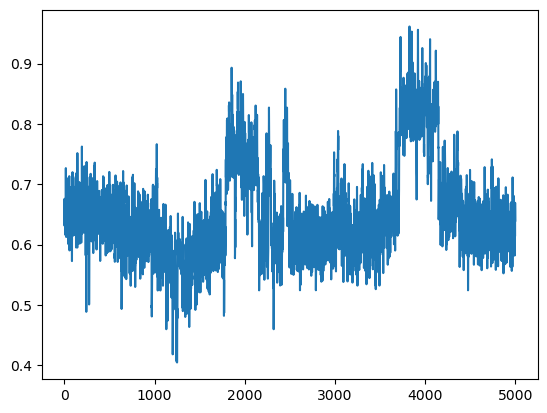

100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


1.0


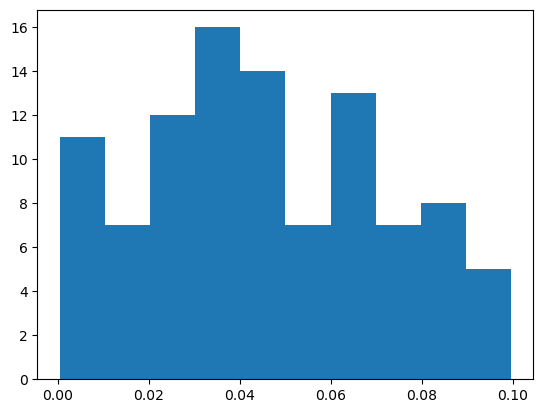

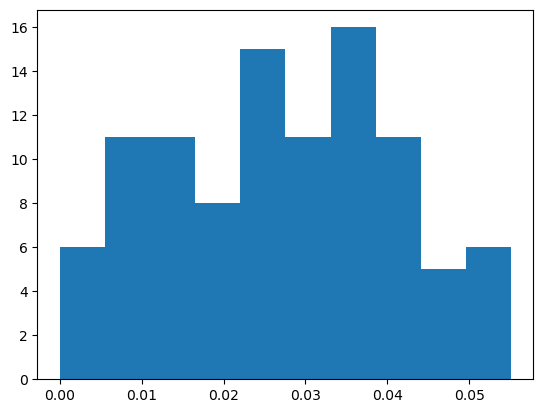

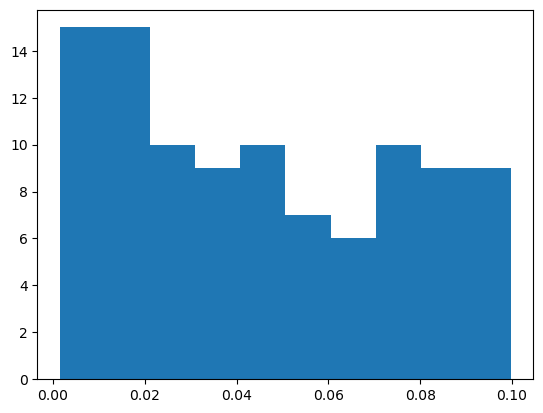

100%|██████████| 100/100 [00:16<00:00,  6.08it/s]

0.9526315789473684


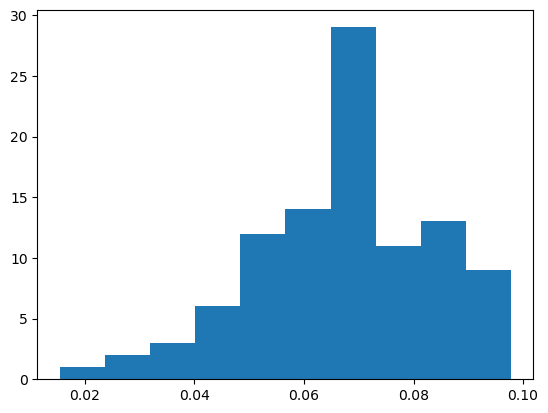

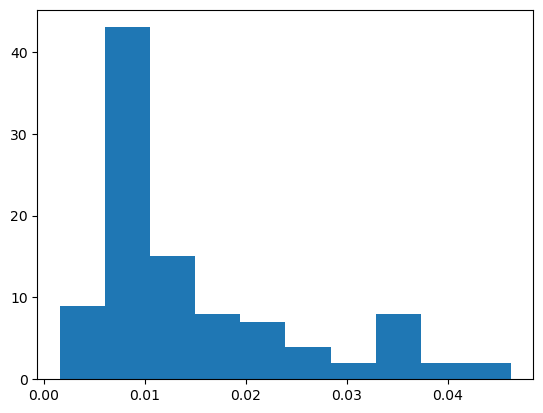

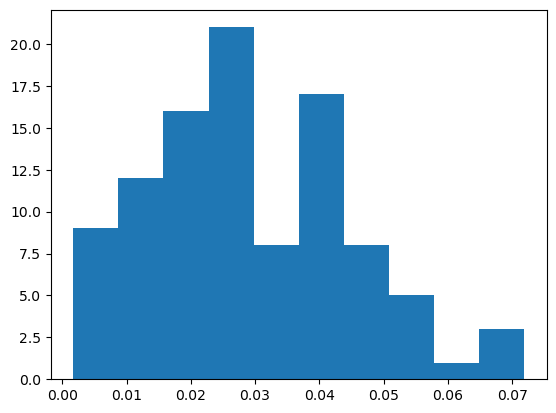

100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


0.9052631578947369


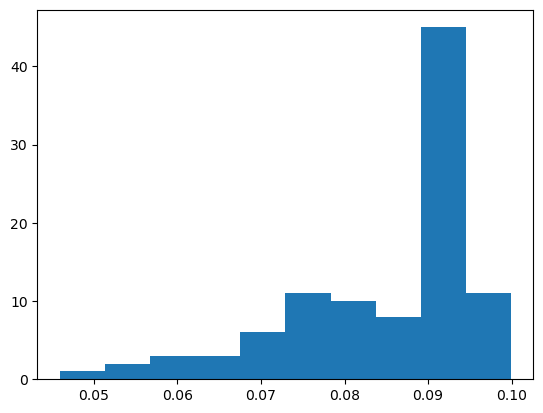

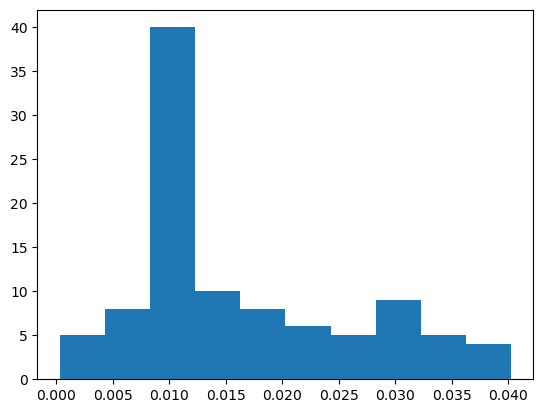

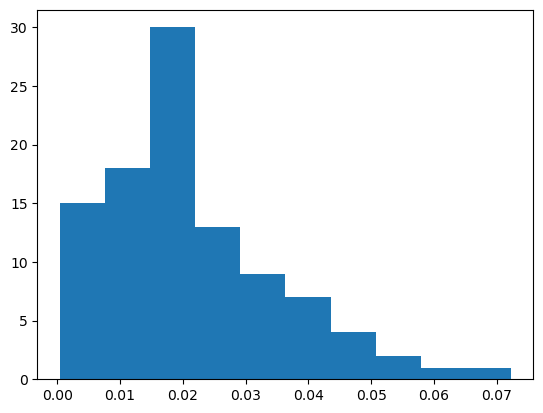

100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


0.8578947368421053


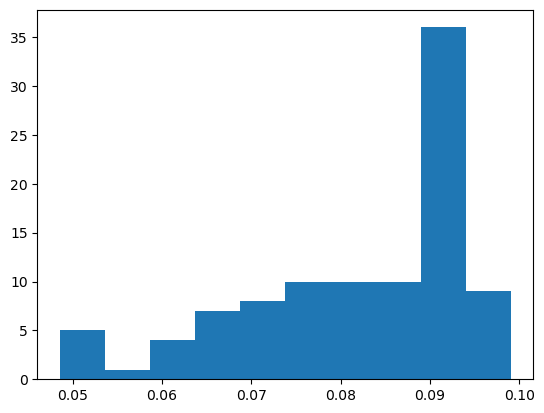

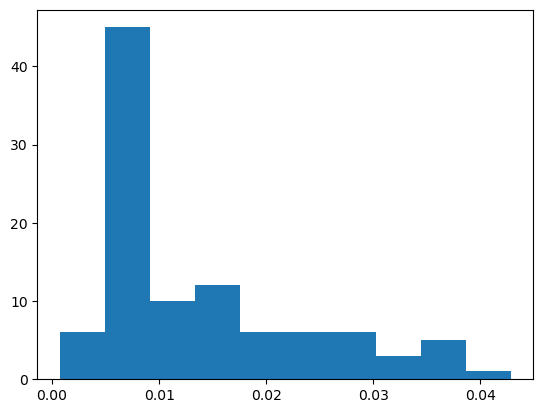

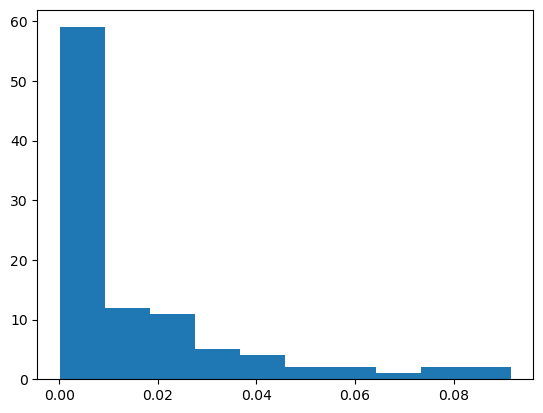

100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


0.8105263157894737


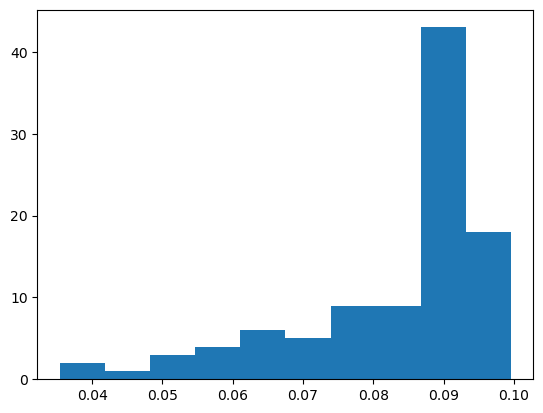

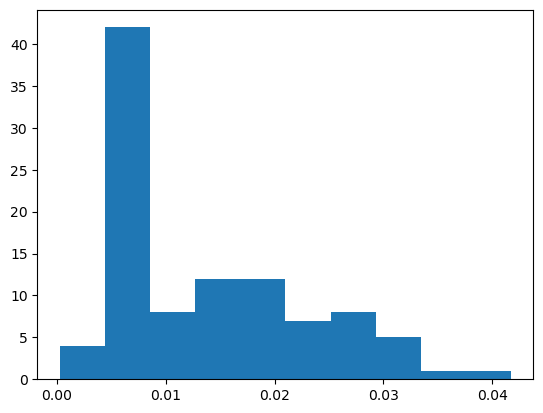

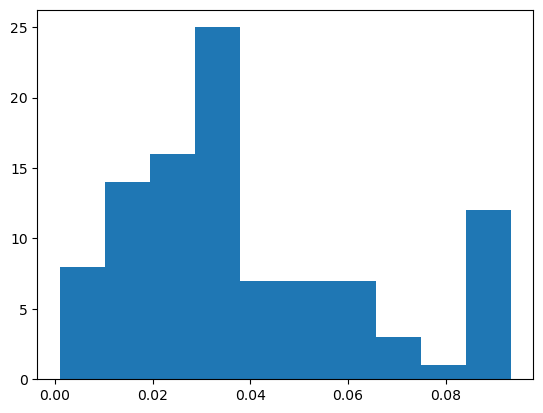

100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


0.763157894736842


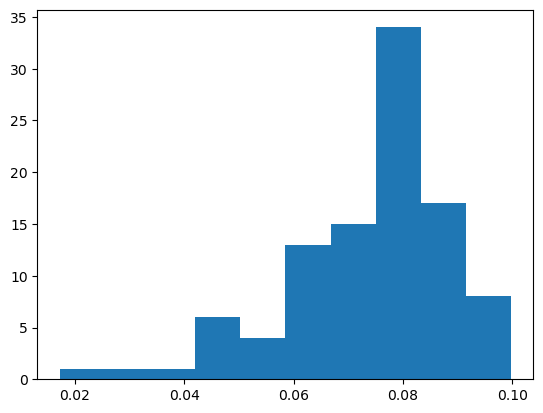

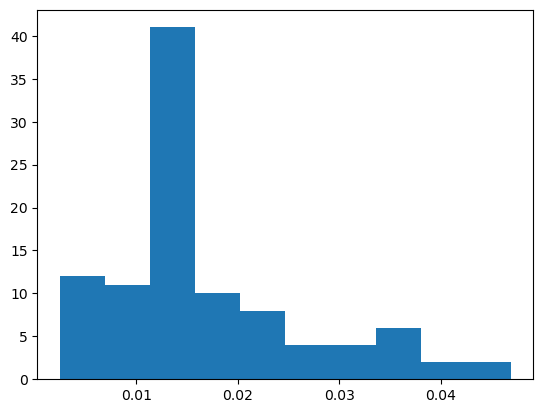

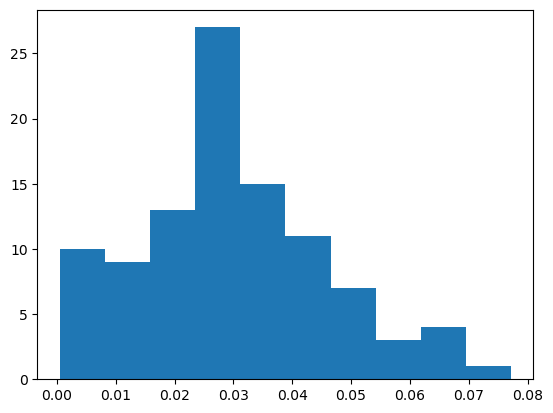

100%|██████████| 100/100 [00:36<00:00,  2.74it/s]

0.7157894736842105


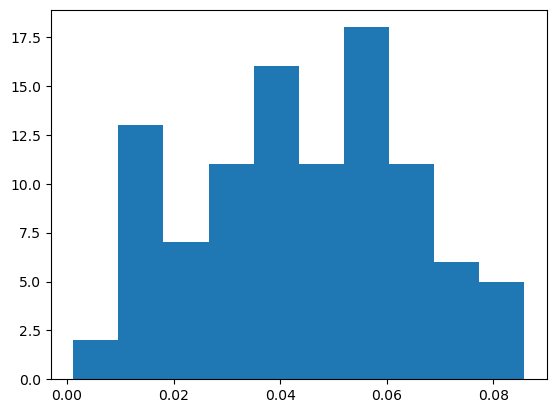

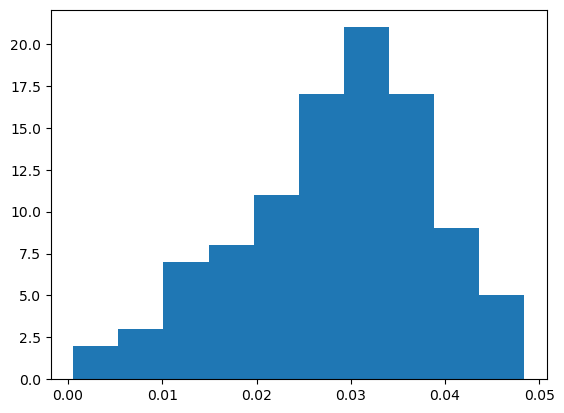

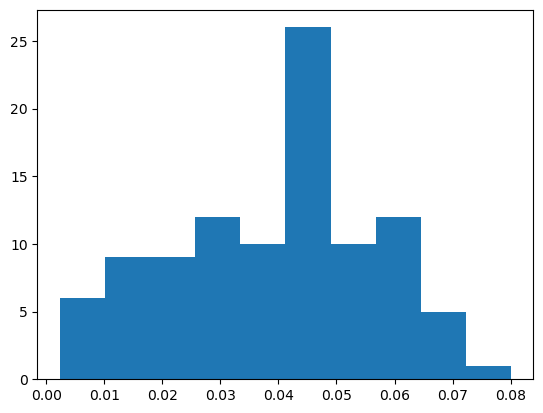

100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


0.6684210526315789


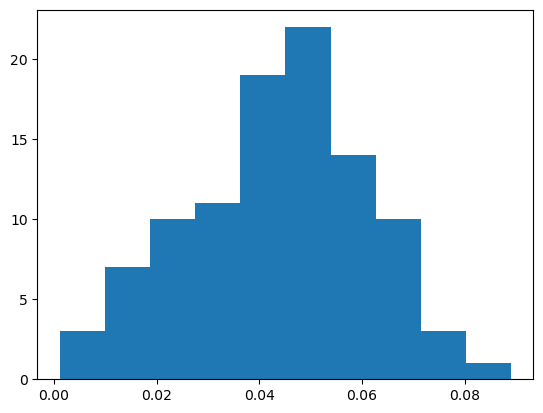

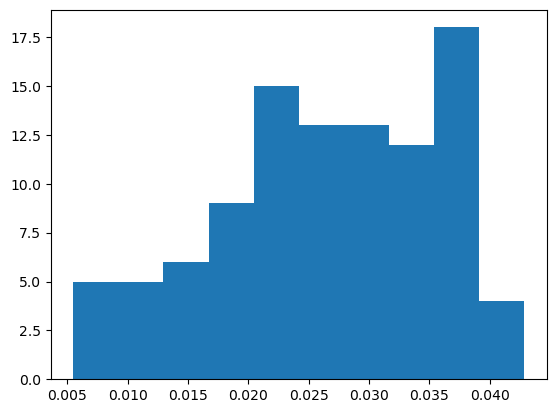

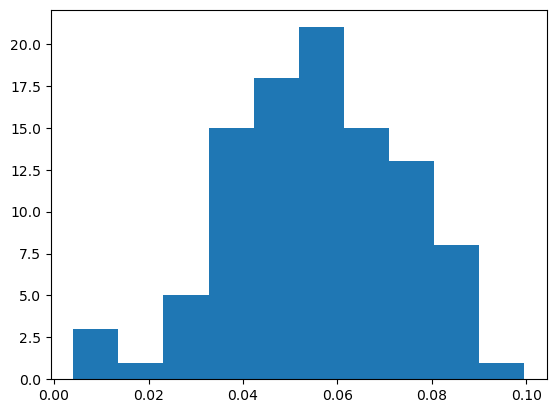

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


0.6210526315789473


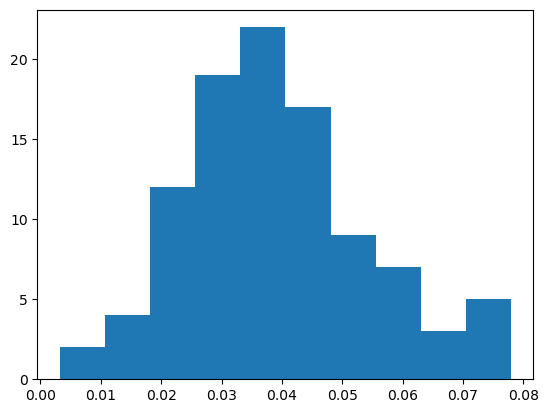

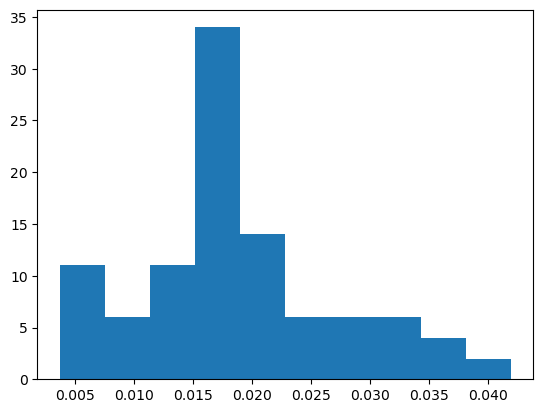

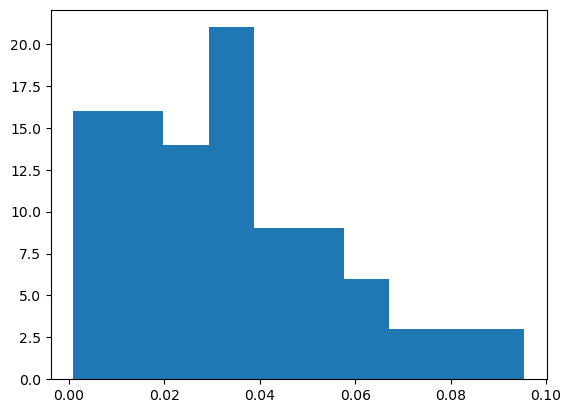

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]

0.5736842105263158


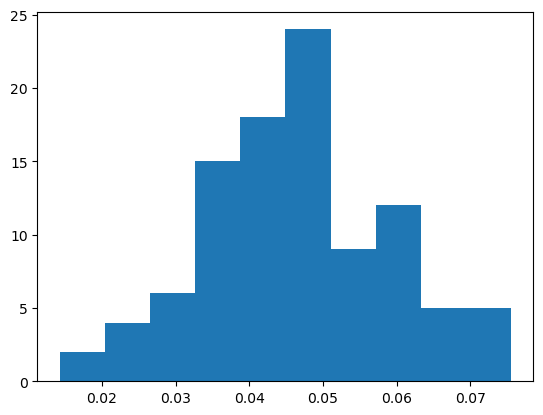

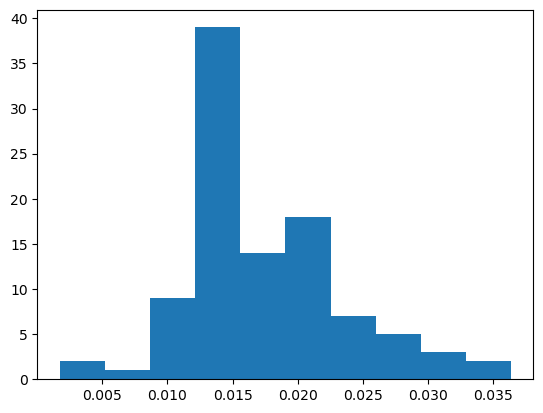

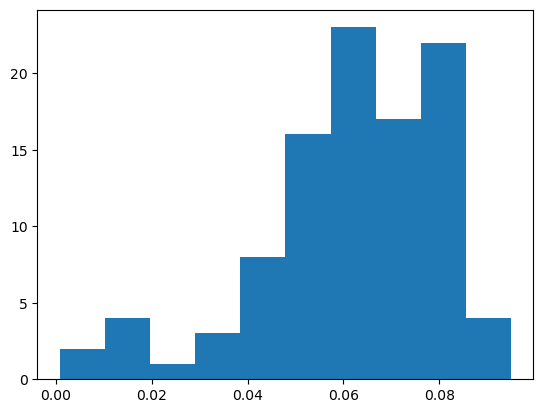

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]

0.5263157894736842


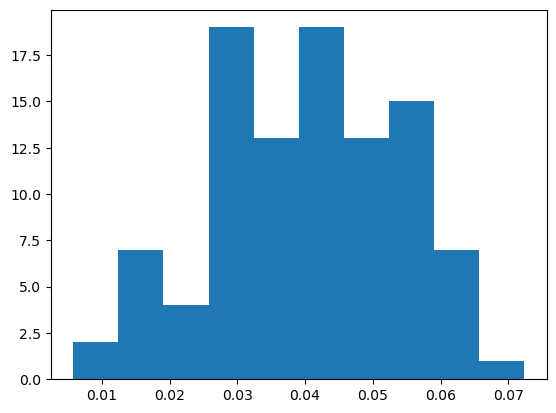

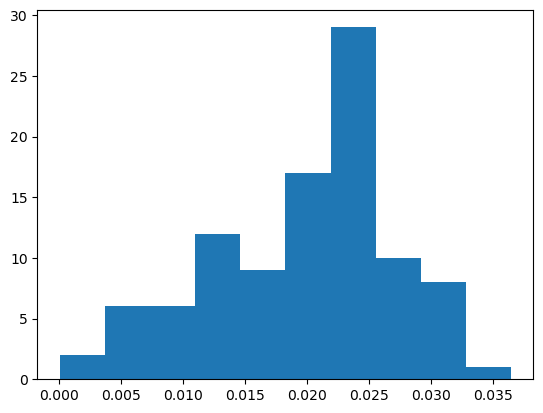

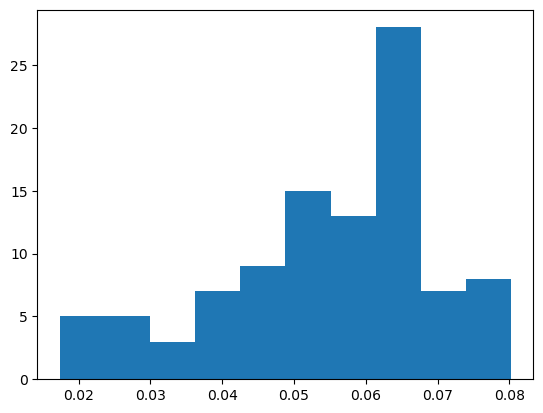

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]

0.47894736842105257


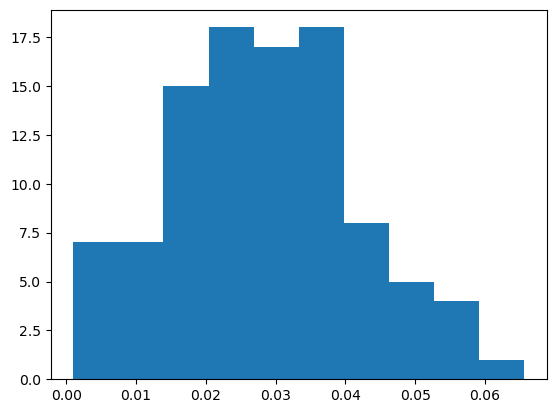

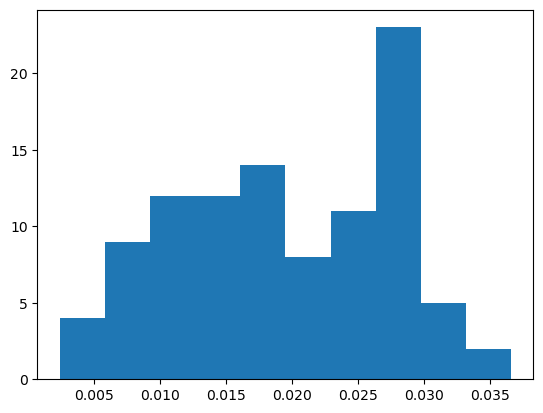

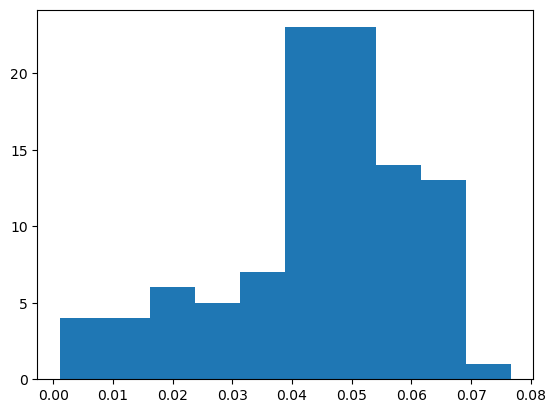

100%|██████████| 100/100 [03:02<00:00,  1.83s/it]

0.43157894736842106


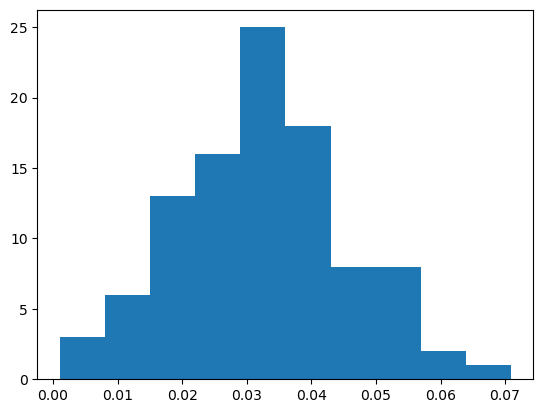

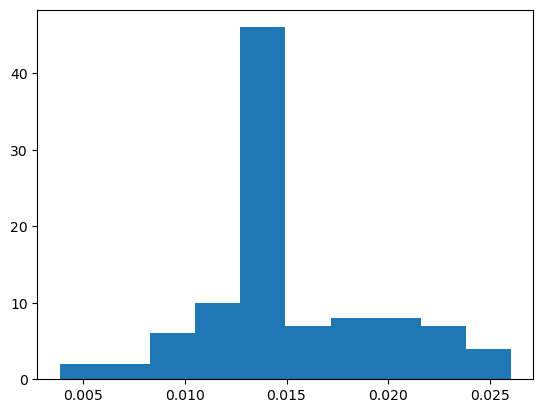

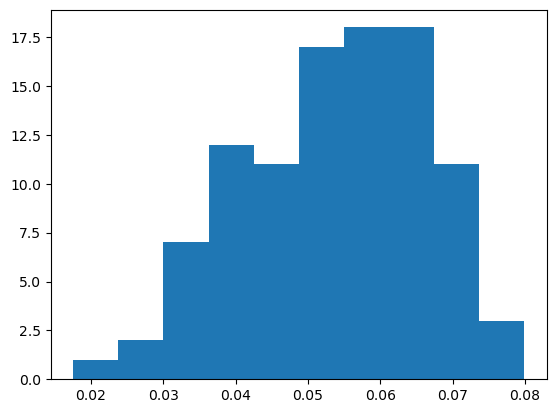

100%|██████████| 100/100 [03:36<00:00,  2.17s/it]

0.38421052631578945


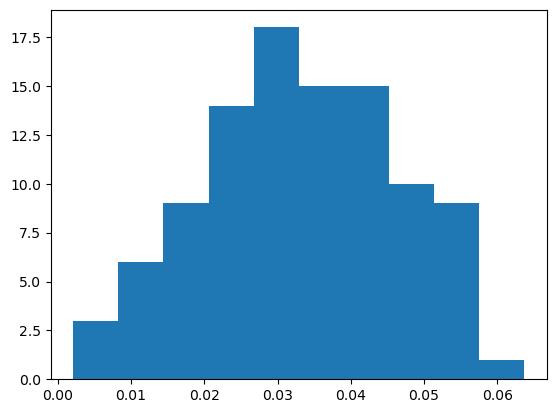

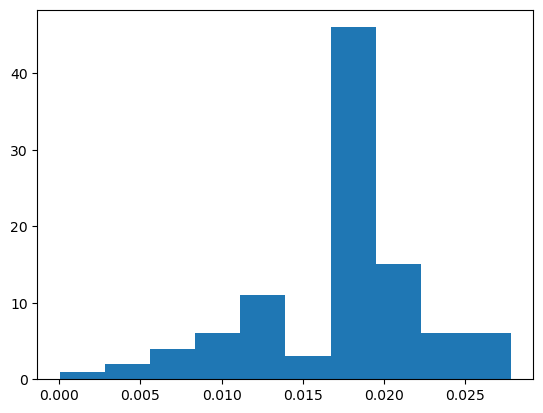

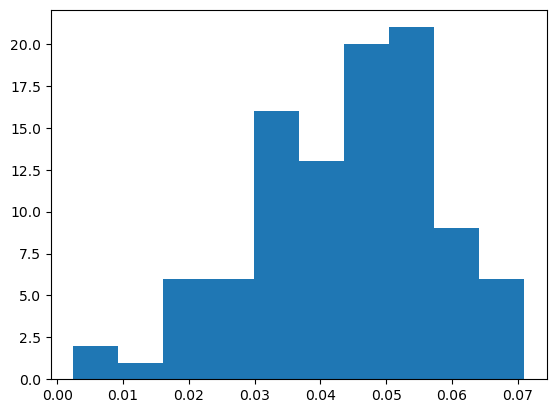

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]

0.33684210526315783


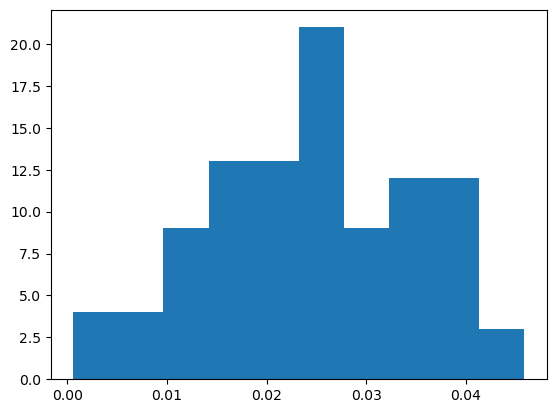

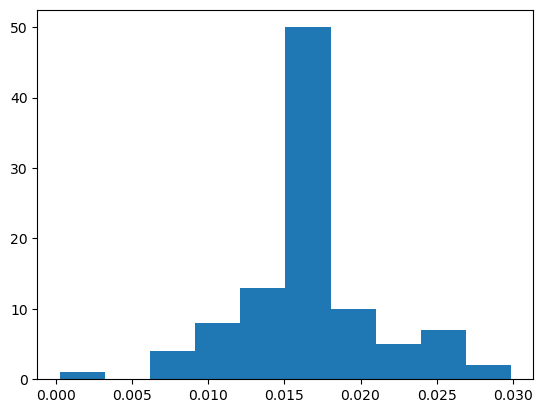

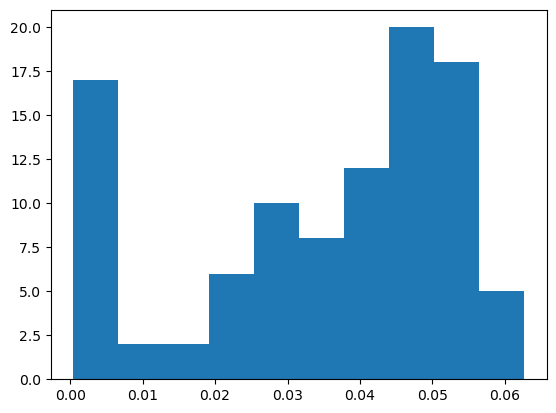

100%|██████████| 100/100 [01:09<00:00,  1.43it/s]

0.2894736842105263


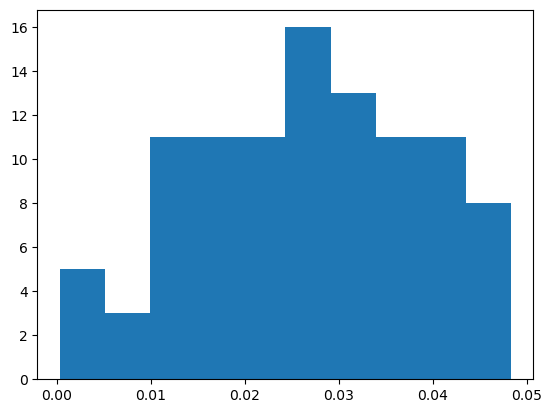

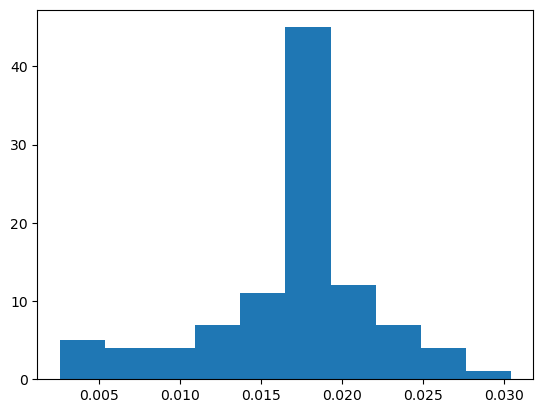

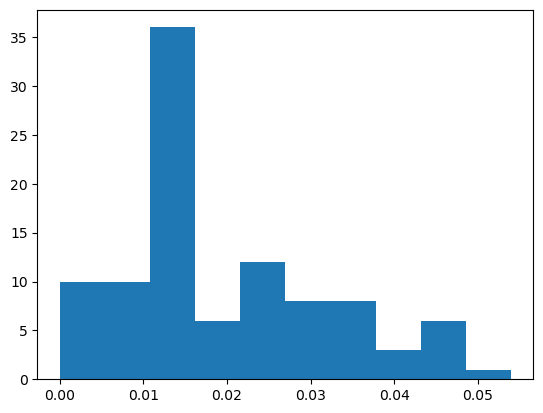

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


0.2421052631578947


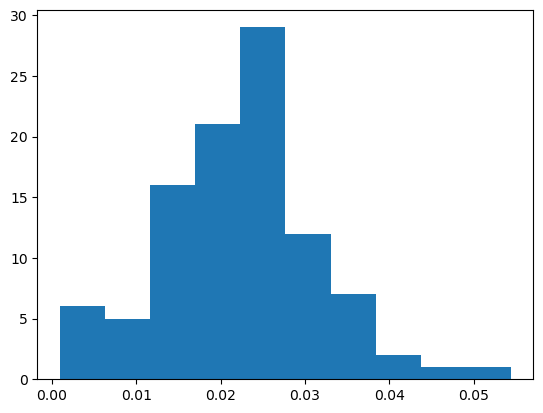

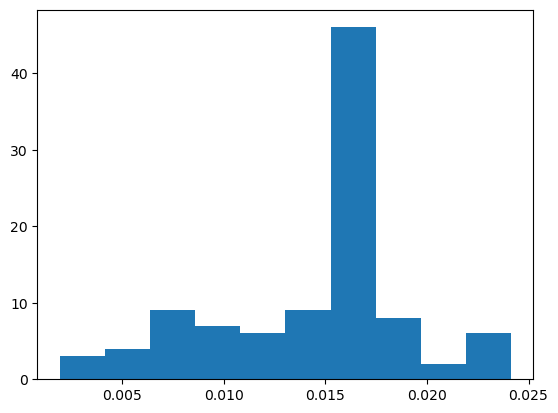

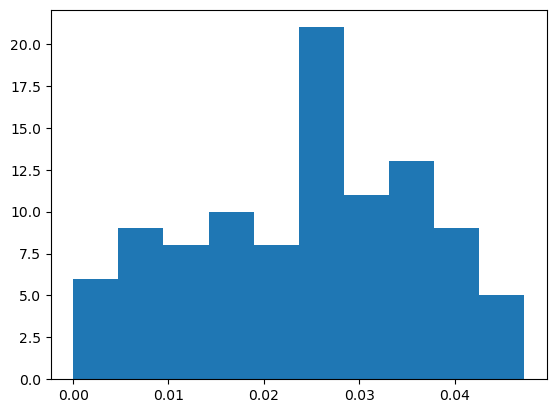

100%|██████████| 100/100 [02:21<00:00,  1.42s/it]

0.1947368421052631


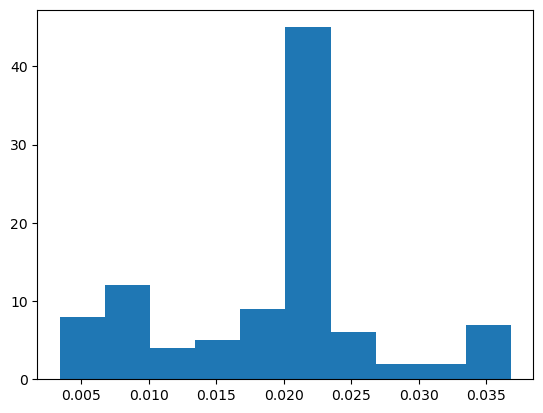

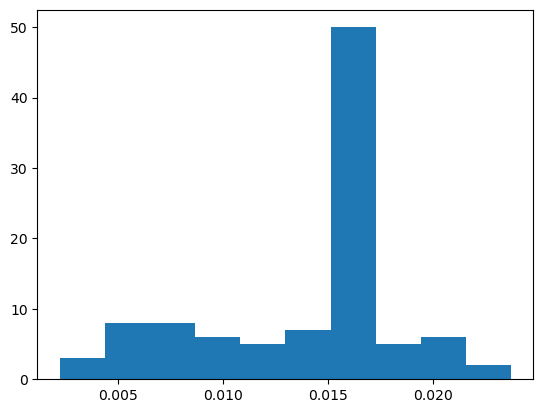

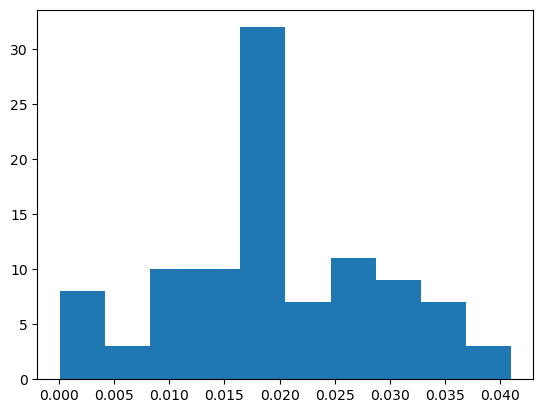

100%|██████████| 100/100 [04:09<00:00,  2.50s/it]

0.1473684210526316


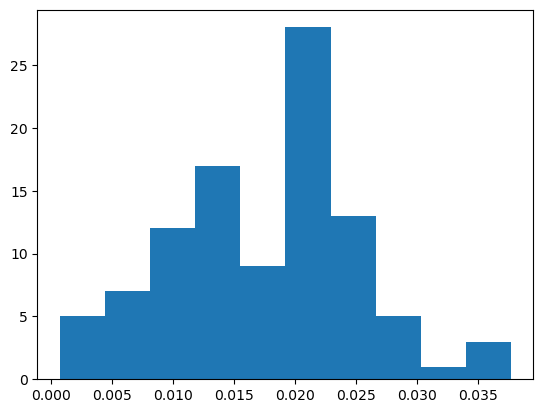

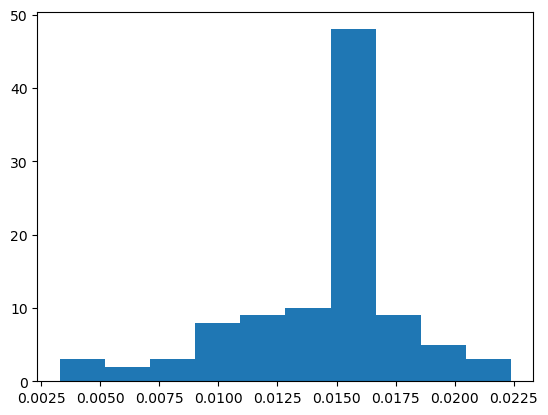

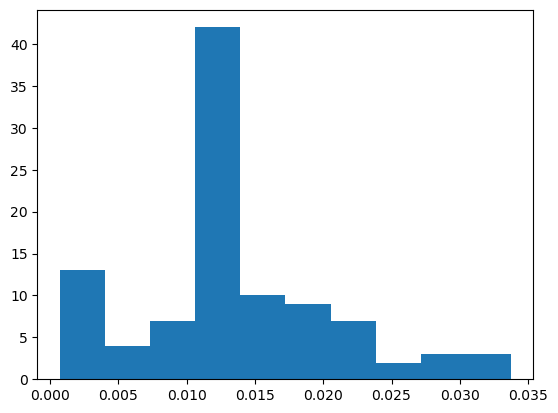

100%|██████████| 100/100 [12:15<00:00,  7.36s/it]

0.1


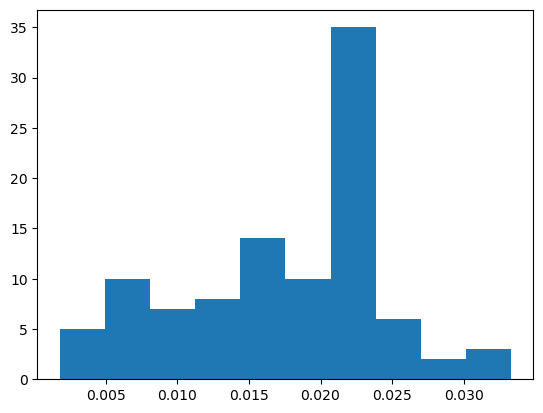

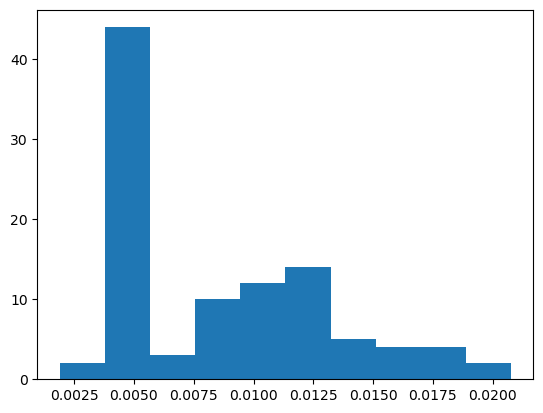

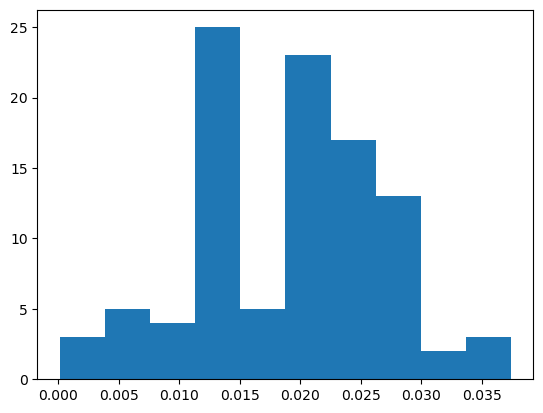

100%|██████████| 100/100 [12:12<00:00,  7.32s/it]

0.098


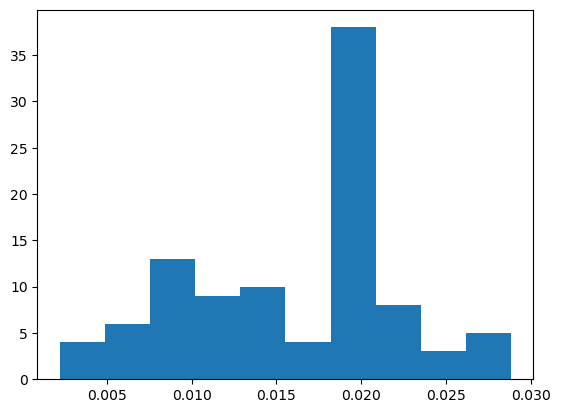

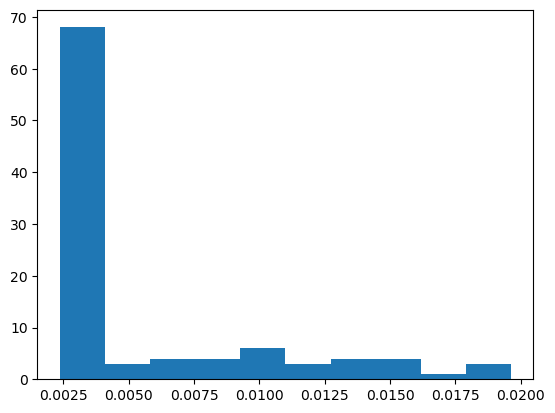

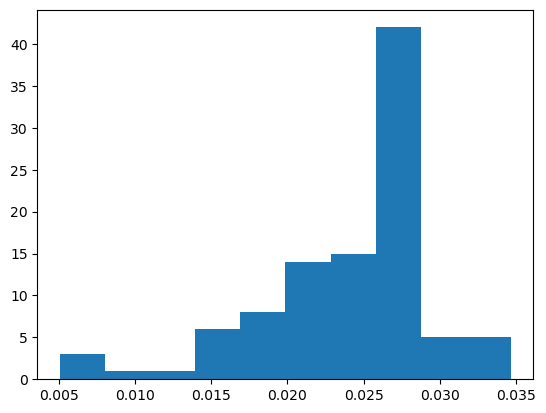

100%|██████████| 100/100 [11:00<00:00,  6.60s/it]


0.09336842105263159


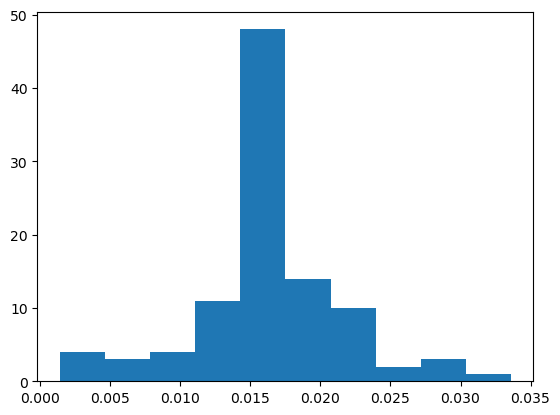

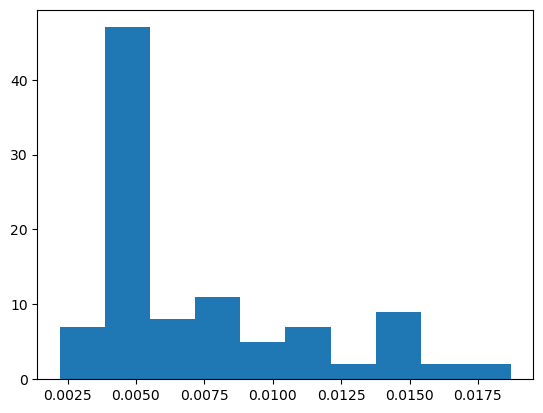

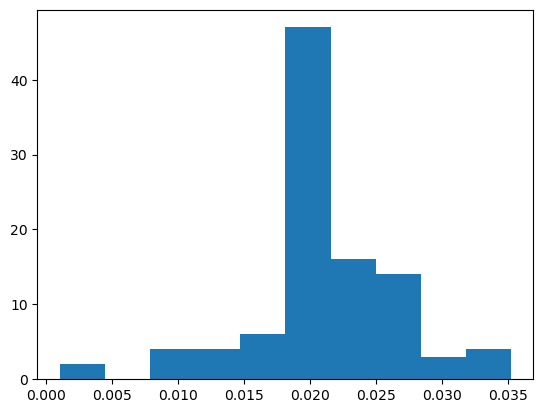

100%|██████████| 100/100 [13:11<00:00,  7.92s/it]

0.08873684210526316


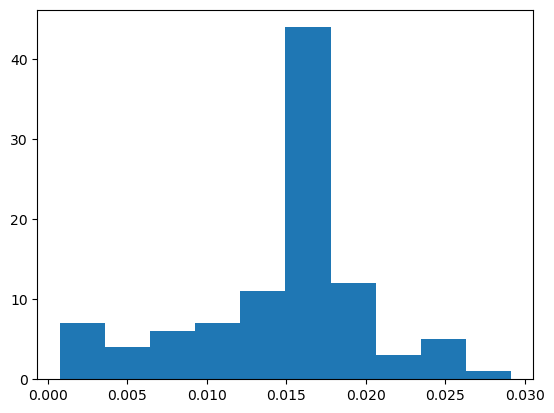

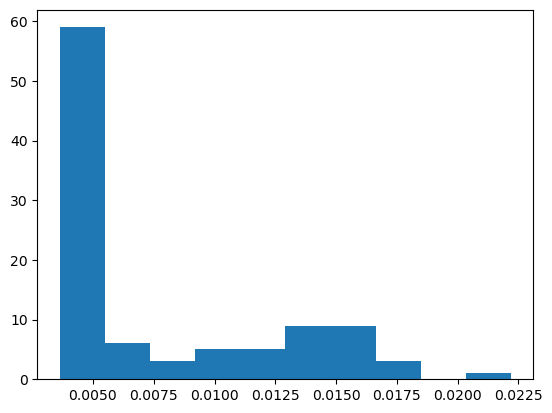

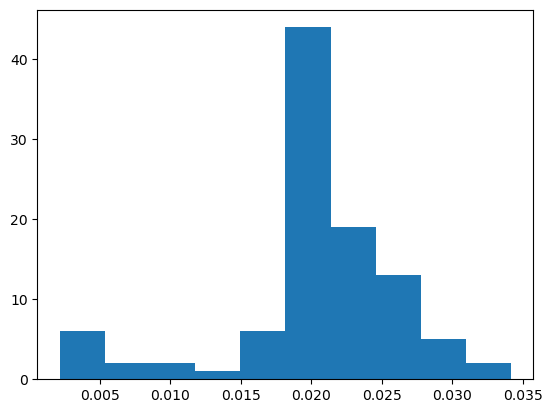

100%|██████████| 100/100 [10:32<00:00,  6.33s/it]

0.08410526315789474


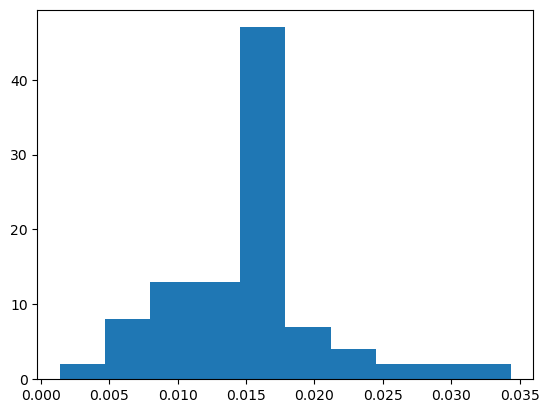

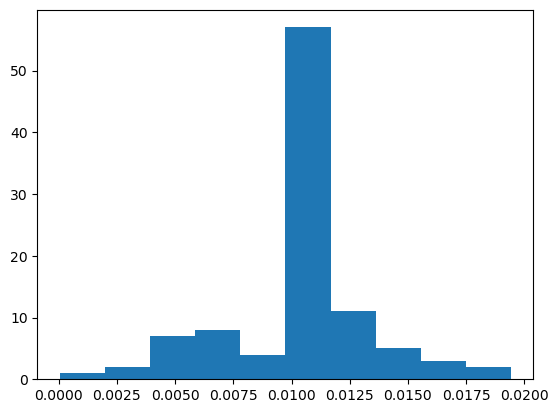

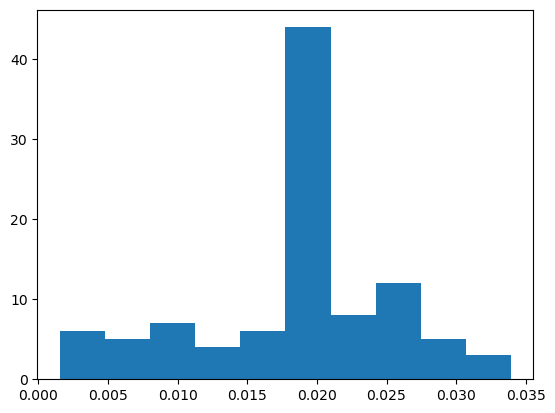

100%|██████████| 100/100 [15:56<00:00,  9.57s/it]

0.07947368421052632


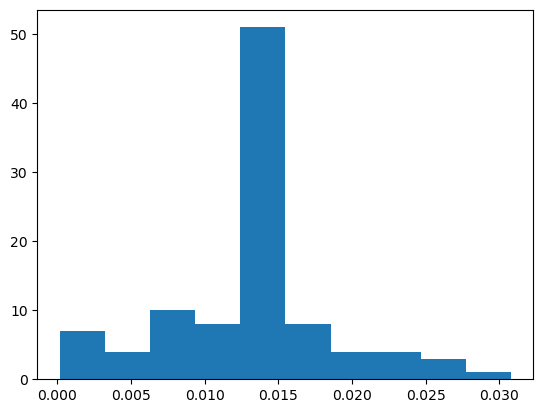

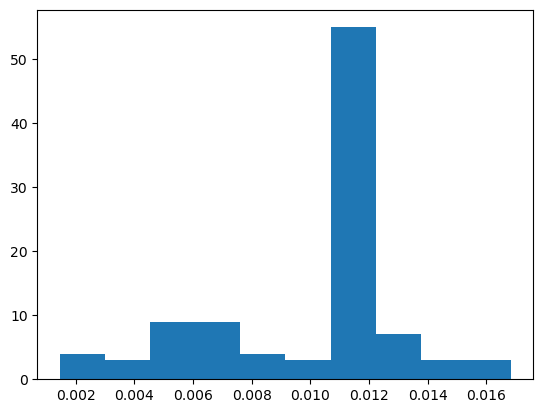

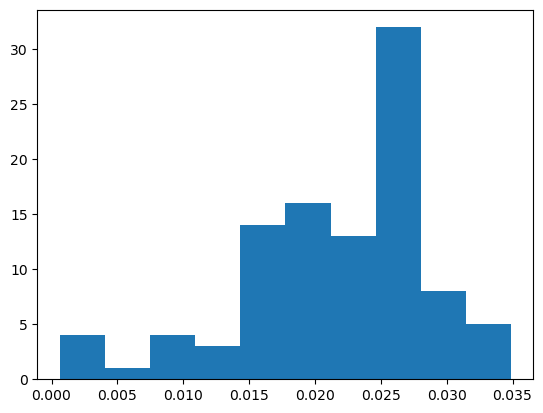

100%|██████████| 100/100 [26:21<00:00, 15.81s/it]

0.0748421052631579


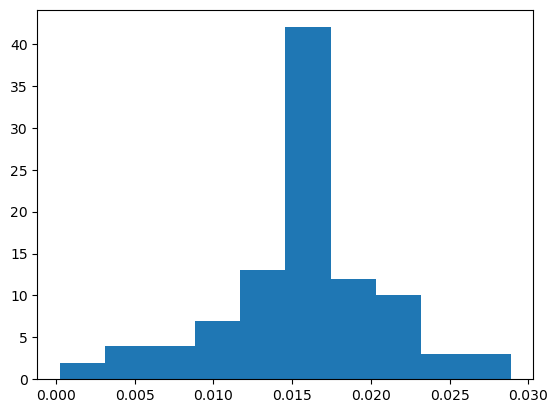

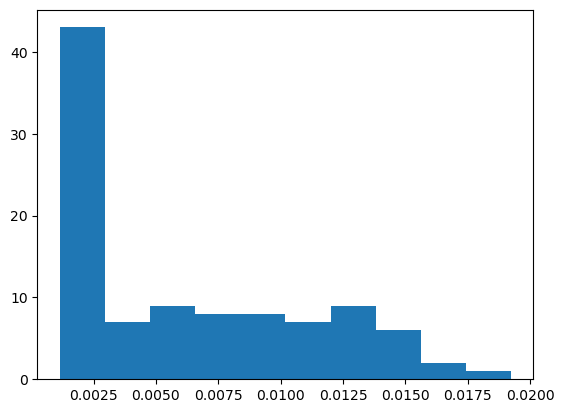

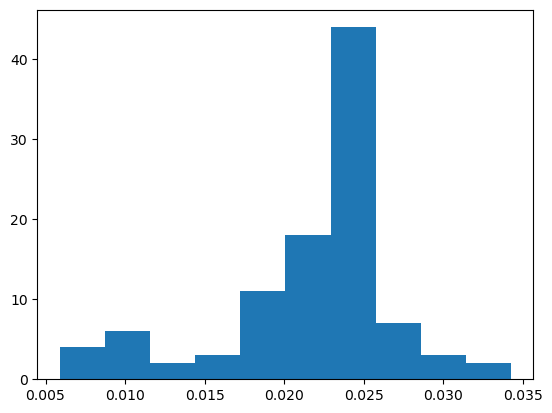

100%|██████████| 100/100 [28:01<00:00, 16.82s/it]

0.07021052631578947


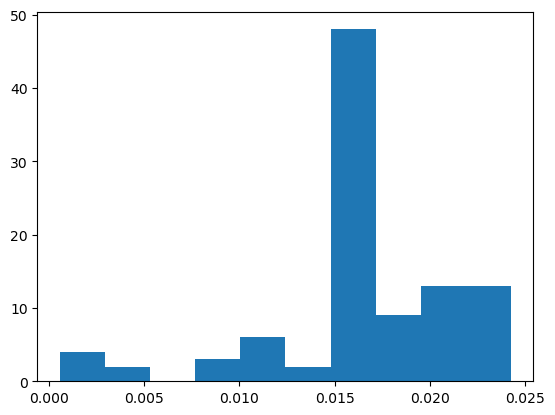

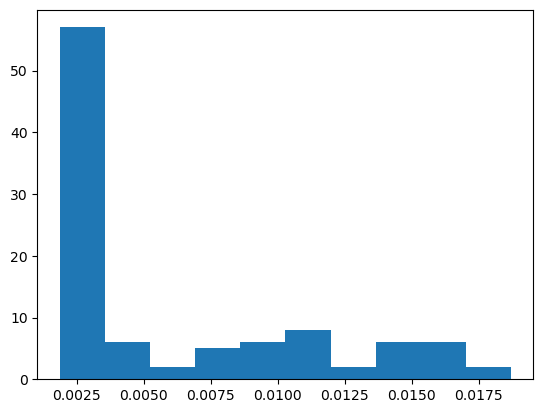

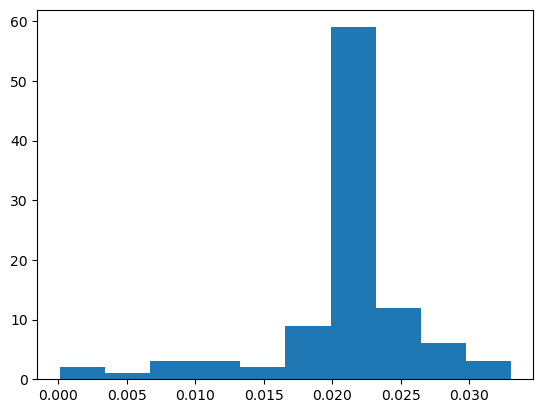

100%|██████████| 100/100 [40:59<00:00, 24.60s/it]

0.06557894736842106


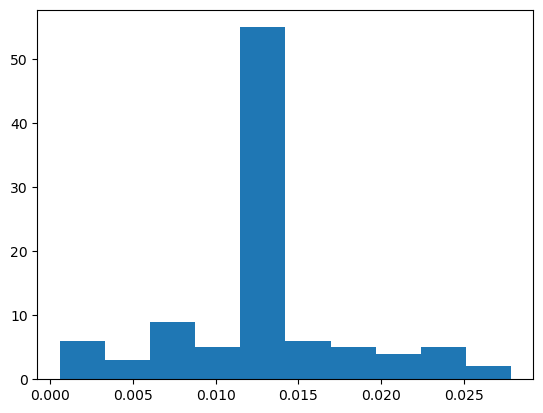

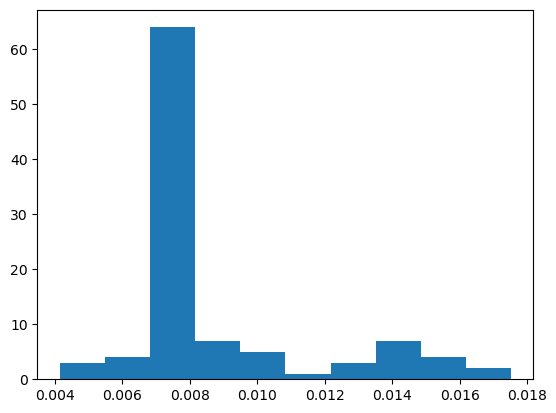

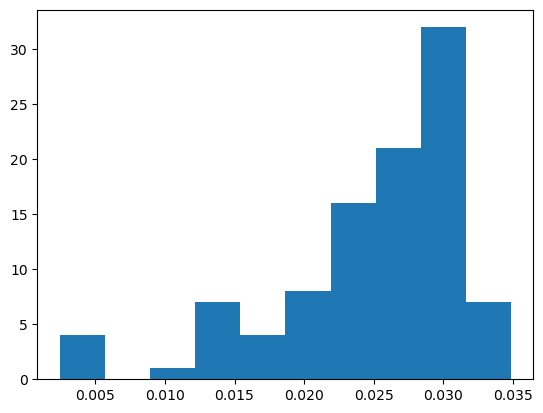

100%|██████████| 100/100 [38:38<00:00, 23.18s/it]

0.06094736842105263


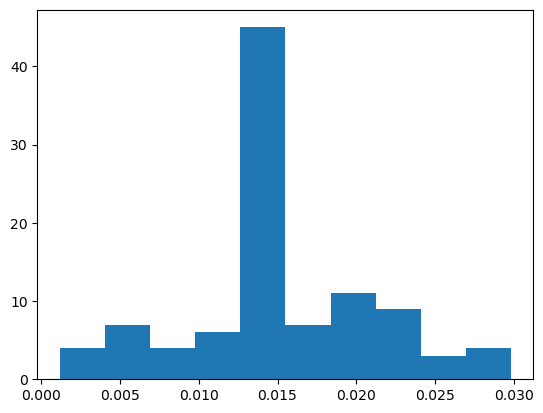

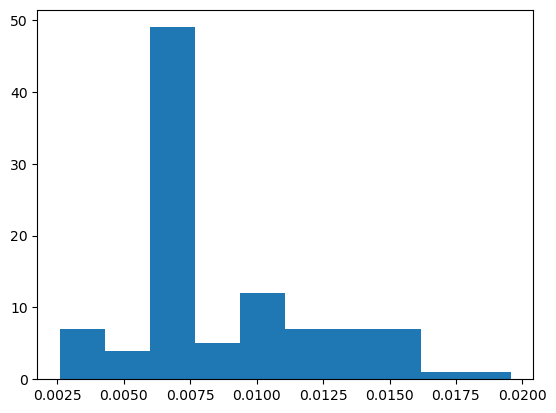

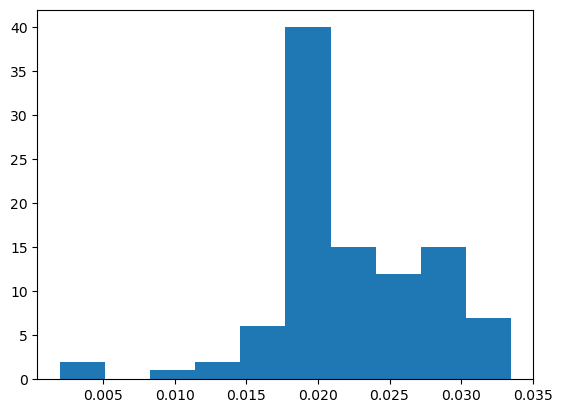

100%|██████████| 100/100 [57:10<00:00, 34.31s/it] 

0.05631578947368421


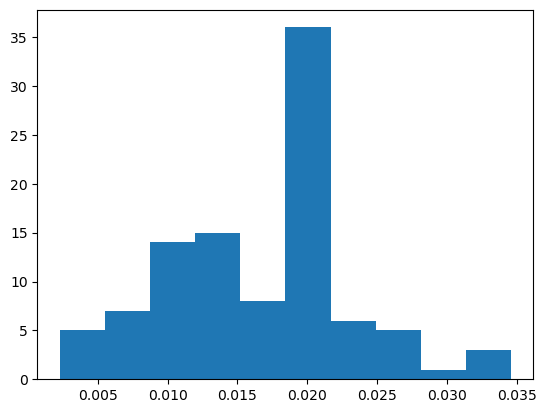

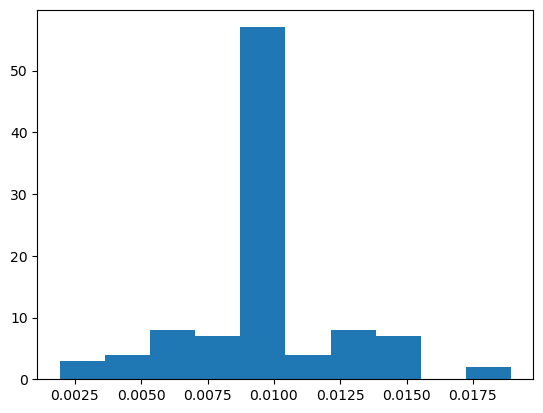

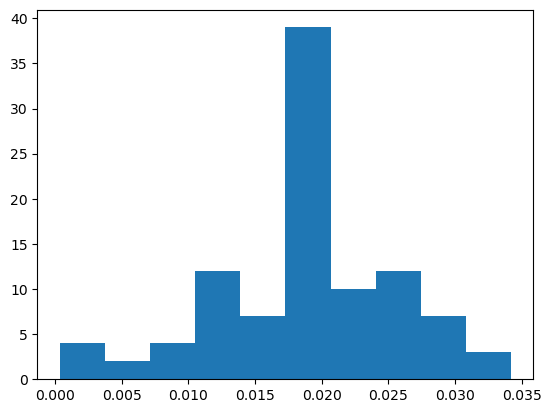

 13%|█▎        | 13/100 [08:41<58:11, 40.13s/it]  


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# Generate data
data = fm.IvanovModel(w_SA=0.01, w_SS=0.01, w_PS=0.03, Num_beats=5000, std_eta=math.sqrt(2)*0.5)

plt.plot(data)
plt.show()

thresholds1 = np.linspace(1, 0.1, 20)
thresholds2 = np.linspace(0.098, 0.01, 20)
thresholds3 = np.linspace(0.0098, 0.005, 20)
thresholds = np.concatenate((thresholds1, thresholds2, thresholds2))
t = 0
result1 = []
result2 = []
result3 = []

start_time = time.time()

# ABC SMC
for thresh in thresholds:
    result1, result2, result3 = ABC_SMC_Ivanov_3(data, 100, thresh, t, result1, result2, result3, start_time)
    t += 1

    theta_result1 = []
    theta_result2 = []
    theta_result3 = []

    for j in range(len(result1)):
        theta_result1.append(result1[j][0])

    for j in range(len(result2)):
        theta_result2.append(result2[j][0])

    for j in range(len(result3)):
        theta_result3.append(result3[j][0])

    if(len(result1)==0):
        break

    print(thresh)

    # Plot iteration estimations
    plt.hist(theta_result1)
    plt.show()

    plt.hist(theta_result2)
    plt.show()

    plt.hist(theta_result3)
    plt.show()

In [ ]:
def histogram_plot(results, xlabel):

    fig, axis = plt.subplots()
    axis.hist(results,  color="lightblue", ec="black", bins=20)
    #plt.title(title)
    plt.xlabel(xlabel)
    #plt.ylabel("Number of estimations w*")

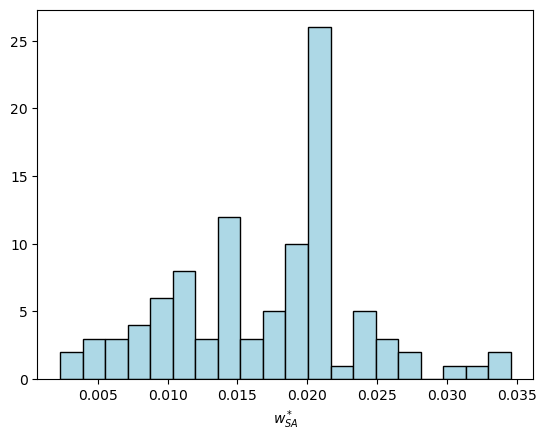

[0.014507554145272963, 0.011101578101351688, 0.021498357533555102, 0.021498357533555102, 0.014172671426837499, 0.014346011988247104, 0.007536173163307061, 0.021498357533555102, 0.021498357533555102, 0.02268744195393218, 0.0027934750937738985, 0.03459395805485047, 0.021498357533555102, 0.019242781026256962, 0.016103345740585934, 0.020344986494816534, 0.02564408909883708, 0.005714294921912458, 0.018855148458670448, 0.021498357533555102, 0.023302072018869385, 0.018647319478758542, 0.011905712936775831, 0.021498357533555102, 0.01824530716411045, 0.00722381659567068, 0.01383091179633113, 0.019124882897790345, 0.015344597861662137, 0.010507178046727492, 0.02487531314346796, 0.010246112304714337, 0.014423003722762145, 0.01722340273127308, 0.01984971928791664, 0.014132780213111911, 0.03248373867911394, 0.005833695995110612, 0.014475542727970653, 0.024169972440613332, 0.021498357533555102, 0.021498357533555102, 0.007943193241667321, 0.03369105786045797, 0.026809727806609365, 0.02149835753355510

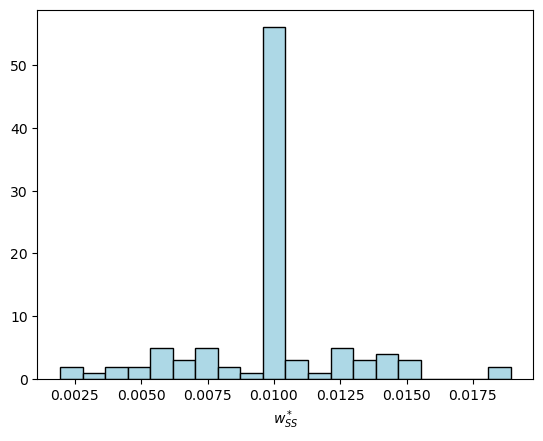

[0.010355517010992472, 0.009382024420943762, 0.010355517010992472, 0.010355517010992472, 0.010355517010992472, 0.007420522829185644, 0.010355517010992472, 0.010355517010992472, 0.013571555864907991, 0.014666019828716046, 0.010355517010992472, 0.010124453649671088, 0.008522943147192798, 0.010355517010992472, 0.010355517010992472, 0.010355517010992472, 0.010355517010992472, 0.010355517010992472, 0.007587529541566392, 0.012547557626352023, 0.010355517010992472, 0.010355517010992472, 0.010355517010992472, 0.010355517010992472, 0.004597603174367585, 0.010355517010992472, 0.004120266110762901, 0.010355517010992472, 0.01252684133821217, 0.007757481569207312, 0.01420341498654504, 0.012371100107822169, 0.010355517010992472, 0.015473350525126897, 0.010355517010992472, 0.007225561447075665, 0.010355517010992472, 0.010355517010992472, 0.014847452845539157, 0.010355517010992472, 0.010355517010992472, 0.010355517010992472, 0.006423130965197678, 0.010355517010992472, 0.010363112287330773, 0.003691537

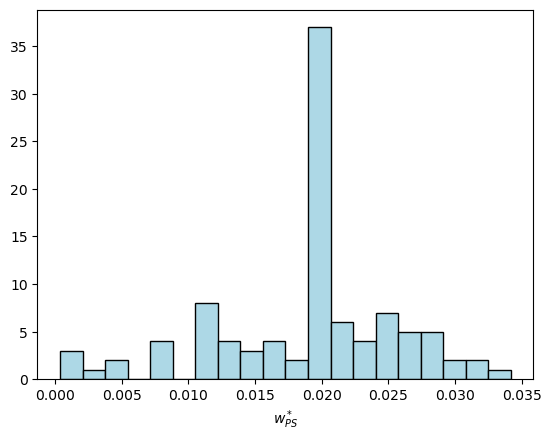

[0.019564380913554693, 0.02606873467948123, 0.019564380913554693, 0.02484787058785467, 0.019564380913554693, 0.02775563605957808, 0.019564380913554693, 0.017022099654039027, 0.019564380913554693, 0.005375471718414102, 0.03206112106643828, 0.028753001473805932, 0.01966471248505412, 0.020625970292255828, 0.034182038123000656, 0.024036560522093527, 0.019564380913554693, 0.027564983875695694, 0.021894030978600786, 0.01497784293906894, 0.013144716712129394, 0.01589353081920594, 0.02200340474214929, 0.013019632951637623, 0.021389320040932268, 0.019564380913554693, 0.02312994709057603, 0.02049560217743807, 0.0073179406796757066, 0.019564380913554693, 0.0005141414185653344, 0.019564380913554693, 0.019564380913554693, 0.024713055698391308, 0.019564380913554693, 0.019564380913554693, 0.00037124619852275595, 0.015172290162588632, 0.02185728365391576, 0.019564380913554693, 0.019564380913554693, 0.010645731599863694, 0.030721473868622097, 0.019564380913554693, 0.00745386169186479, 0.022595069092398

In [ ]:
histogram_plot(theta_result1, r"$w_{SA}^*$")
plt.savefig("wSA_abc.pdf")
plt.show()
print(theta_result1)

histogram_plot(theta_result2,  r"$w_{SS}^*$")
plt.savefig("wSS_abc.pdf")
plt.show()
print(theta_result2)

histogram_plot(theta_result3,  r"$w_{PS}^*$")
plt.savefig("wPS_abc.pdf")
plt.show()
print(theta_result3)
